In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import cv2

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from tqdm.notebook import tqdm

from quinn_embedding_stimuli import *
from quinn_embedding_models import *

In [3]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## Plotting and analysis functions


In [4]:
BATCH_SIZE = 64
    
    
def plot_tsne(tsne_out, target_positions, reference_positions=[], data=None):
    display(Markdown('Plot on the left: colored by the row (vertical position) of the target object'))
    display(Markdown('Plot on the right: colored by the column (horizontal position) of the target object'))
    
    if reference_positions and len(reference_positions) != len(target_positions):
        reference_positions = [reference_positions[0]] * len(target_positions)
    
    row_colors = np.array([x[0] for x in target_positions])
    row_colors = row_colors / row_colors.max()

    col_colors = np.array([x[1] for x in target_positions])
    col_colors = col_colors / col_colors.max()
    
    plt.figure(figsize=(20, 8))
    cmap = matplotlib.cm.get_cmap('Spectral_r')

    row_color_ax = plt.subplot(1, 2, 1)
    mappable = row_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=row_colors, cmap=cmap)
    row_color_ax.set_title('Color by row')

    col_color_ax = plt.subplot(1, 2, 2)
    col_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=col_colors, cmap=cmap)
    
    col_color_ax.set_title('Color by column')

#     plt.colorbar(mappable)
    plt.show()
    
    
def plot_tsne_miniature_stimuli(tsne_out, target_positions, reference_positions, data,
                                stim_size_percent=0.05, border_width=1, epsilon=0.05,
                                color_border_by=None, figsize=(12, 12), dpi=200):
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    
    if color_border_by is None:
        color_border_by = ''
    
    if color_border_by.lower() in ('row', 'vert', 'vertical'):
        color_border_by = 'row'
        display(Markdown('Border colored by the row (vertical position) of the target object'))
    elif color_border_by.lower() in ('column', 'col', 'horiz', 'horizontal'):
        color_border_by = 'column'
        display(Markdown('Border colored by the column (horizontal position) of the target object'))
    
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.subplot(1, 1, 1)
    
    x_min, x_max = tsne_out[:, 0].min(), tsne_out[:, 0].max()
    x_range = x_max - x_min
    y_min, y_max = tsne_out[:, 1].min(), tsne_out[:, 1].max()
    y_range = y_max - y_min
    x_margin, y_margin = plt.margins()
    
    ax.set_xlim(x_min - (x_range * x_margin), x_max + (x_range * x_margin))
    ax.set_ylim(y_min - (y_range * y_margin), y_max + (y_range * y_margin))
    
    stim_width = stim_size_percent * x_range
    half_width = stim_width / 2
    stim_height = stim_size_percent * y_range
    half_height = stim_height / 2
    
    for (x, y), stimulus, target_pos in zip(tsne_out, data, target_positions):
        left = x - half_width
        right = x + half_width
        bottom = y - half_height
        top = y + half_height
        ax.imshow(stimulus.permute(1, 2, 0).cpu().numpy(), extent=(left, right, bottom, top))
        
        border_color = 'black'
        if color_border_by.lower() == 'row':
            border_color = cmap(target_pos[0] / 224)
        elif color_border_by.lower() == 'column':
            border_color = cmap(target_pos[1] / 224)
        
        border = matplotlib.patches.Rectangle((left - epsilon, bottom - epsilon), 
                                          right - left + 2 * epsilon, top - bottom + 2 * epsilon,
                                          fc='none', ec=border_color, lw=1)
        ax.add_patch(border)
        
    plt.show()
    
    
def plot_tsne_quiver(tsne_out, target_positions, reference_positions, data,
                     scale=None, figsize=(8, 8), dpi=200, color='magnitude'):
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    
    if not reference_positions:
        reference_positions = [(112, 112)] * len(target_positions)
        
    elif len(reference_positions) < len(target_positions):
        reference_positions = [reference_positions[0]] * len(target_positions)
    
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.subplot(1, 1, 1)
    distances = [(t[1] - r[1], t[0] - r[0])  for t, r in zip(target_positions, reference_positions)]
    x_distances, y_distances = zip(*distances)
    
    if color == 'magnitude':
        d = np.array(distances)
        d = np.power(d, 2).sum(1)
        c = d / d.max()
        mappable = ax.quiver(tsne_out[:, 0], tsne_out[:, 1], x_distances, y_distances, c, angles='xy',
                             scale=scale, cmap=cmap)
#         plt.colorbar(mappable)
    
    else:
        ax.quiver(tsne_out[:, 0], tsne_out[:, 1], x_distances, y_distances, angles='xy',
                  scale=scale)
        
    plt.show()
    

def analyze_single_model(name, model, generator, target_positions, reference_positions=[],
                         batch_size=BATCH_SIZE, random_state=RANDOM_SEED, plot_tsne_func=plot_tsne,
                         plot_kwargs={}, model_in_eval=True):
    display(Markdown(f'## {name}'))
    
    data = generator.batch_generate(target_positions, reference_positions)
    
    target_pos_array = np.array(target_positions)
    target_pos_distances = np.linalg.norm(target_pos_array[:, None, :] - target_pos_array[None, :, :], ord=2, axis=-1)
    target_pos_distances /= np.max(target_pos_distances)
    target_pos_distances = 1 - target_pos_distances
    upper_triangle_indices = np.triu_indices_from(target_pos_distances, 1)
    
    target_distance_arr = target_pos_distances[upper_triangle_indices]
    target_distance_arr = (target_distance_arr - target_distance_arr.mean()) / target_distance_arr.std()
    
    if model_in_eval:
        model.eval()
    else:
        model.train()
    
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=False)

    embeddings = []
    for b in tqdm(dataloader, desc='Batches'):
        embeddings.append(model(b[0].to(device)).detach())

    embeddings = torch.cat(embeddings)
    embeddings_arr = embeddings.cpu().numpy()
    
    cos = nn.CosineSimilarity(dim=-1)
    if embeddings.shape[1] <= 1024:
        embedding_pairwise_cosine = cos(embeddings[:, None, :], embeddings[None, :, :])
        embedding_cosine_arr = embedding_pairwise_cosine[upper_triangle_indices].cpu().numpy()
        
    else:
        cosines = []
        for i in tqdm(range(embeddings.shape[0]), desc='Indices'):
            remainder = embeddings[i + 1:, :]
            current = embeddings[i,:].repeat(remainder.shape[0], 1)

            cosines.append(cos(current, remainder))

        embedding_cosine_arr = torch.cat(cosines).cpu().numpy()
    
    embedding_cosine_arr = (embedding_cosine_arr - embedding_cosine_arr.mean()) / embedding_cosine_arr.std()
    
    display(Markdown(f'### Correlation coefficients:'))
    display(Markdown('Correlation coefficient between full embedding cosine to (1 - distance between targets)'))
    print(np.corrcoef(embedding_cosine_arr, target_distance_arr)[1, 0])
    
    pca_16 = PCA(16, random_state=random_state)
    embeddings_pca_16 = pca_16.fit_transform(embeddings_arr)
    pca_16_cos = metrics.pairwise.cosine_similarity(embeddings_pca_16, embeddings_pca_16)[upper_triangle_indices]
    pca_16_cos = (pca_16_cos - pca_16_cos.mean()) / pca_16_cos.std()
    display(Markdown('Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)'))
    print(np.corrcoef(pca_16_cos, target_distance_arr)[1, 0])
    
    pca = PCA(2, random_state=random_state)
    embeddings_pca = pca.fit_transform(embeddings_arr)
    pca_cos = metrics.pairwise.cosine_similarity(embeddings_pca, embeddings_pca)[upper_triangle_indices]
    pca_cos = (pca_cos - pca_cos.mean()) / pca_cos.std()
    display(Markdown('Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)'))
    print(np.corrcoef(pca_cos, target_distance_arr)[1, 0])
    
    tsne = TSNE(n_jobs=4, init=embeddings_pca, random_state=random_state)
    tsne_out = tsne.fit_transform(embeddings_arr)
    tsne_cos = metrics.pairwise.cosine_similarity(tsne_out, tsne_out)[upper_triangle_indices]
    tsne_cos = (tsne_cos - tsne_cos.mean()) / tsne_cos.std()
    display(Markdown('Correlation coefficient between t-SNE cosine to (1 - distance between targets)'))
    print(np.corrcoef(tsne_cos, target_distance_arr)[1, 0])
    
    display(Markdown(f'------'))
    display(Markdown(f'### t-SNE plots'))
    
    if hasattr(plot_tsne_func, '__len__'):
        for func, kwargs in zip(plot_tsne_func, plot_kwargs):
            if func == plot_tsne_miniature_stimuli:
                plot_data = generator.batch_generate(target_positions, reference_positions, normalize=False)
                func(tsne_out, target_positions, reference_positions, plot_data, **kwargs)
            else:
                func(tsne_out, target_positions, reference_positions, data, **kwargs)
    else:
    
        if plot_tsne_func == plot_tsne_miniature_stimuli:
            plot_data = generator.batch_generate(target_positions, reference_positions, normalize=False)
            plot_tsne_func(tsne_out, target_positions, reference_positions, plot_data, **plot_kwargs)
        else:
            plot_tsne_func(tsne_out, target_positions, reference_positions, data, **plot_kwargs)
        

## Object generator and sample

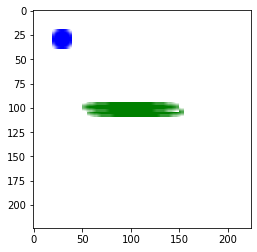

In [5]:
target_size = 20
reference_size = (10, 100)
reference_positions = (105, 100)

target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='green')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, target_patch, reference_patch,
                             blur_func=blur_func)

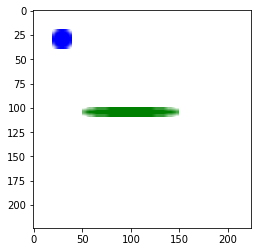

In [8]:
x = gen.generate((30, 30), reference_positions)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

In [20]:
every = 5
half_target = target_size // 2
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
target_positions = [(r * every, c * every) for r, c 
                    in itertools.product(range(half_target // every, row_max // every), 
                                         range(half_target // every, col_max // every))]

# batch = gen.batch_generate(target_positions, reference_positions)
# batch.shape

In [21]:
miniature_stimuli_every = 20
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
miniature_target_positions = [(r * miniature_stimuli_every, c * miniature_stimuli_every) for r, c 
                                in itertools.product(range(1, 
                                                           row_max // miniature_stimuli_every + 1), 
                                                     range(1, 
                                                           col_max // miniature_stimuli_every + 1))]
# miniature_target_positions
# miniature_batch = gen.batch_generate(miniature_target_positions, reference_positions)
# miniature_batch.shape

## Starting to plot models

## ImageNet-pretrained resnet18

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.05968222895824542


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.4127512809578743


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.3739094519010686


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.4188173152721944


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

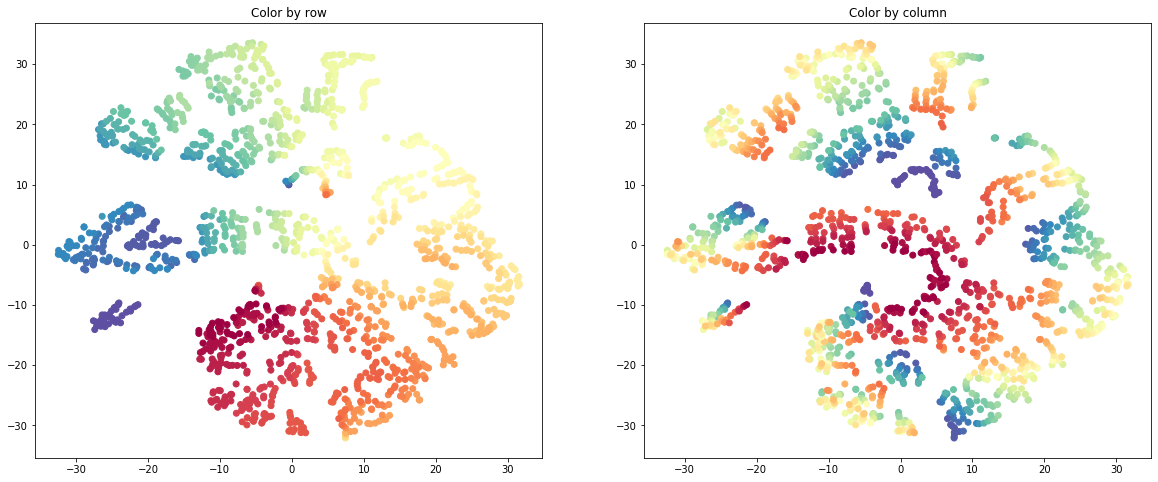

## ImageNet-pretrained resnet18

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.07557629755958459


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.4132886699543406


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.344802296628157


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.43618243903653475


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

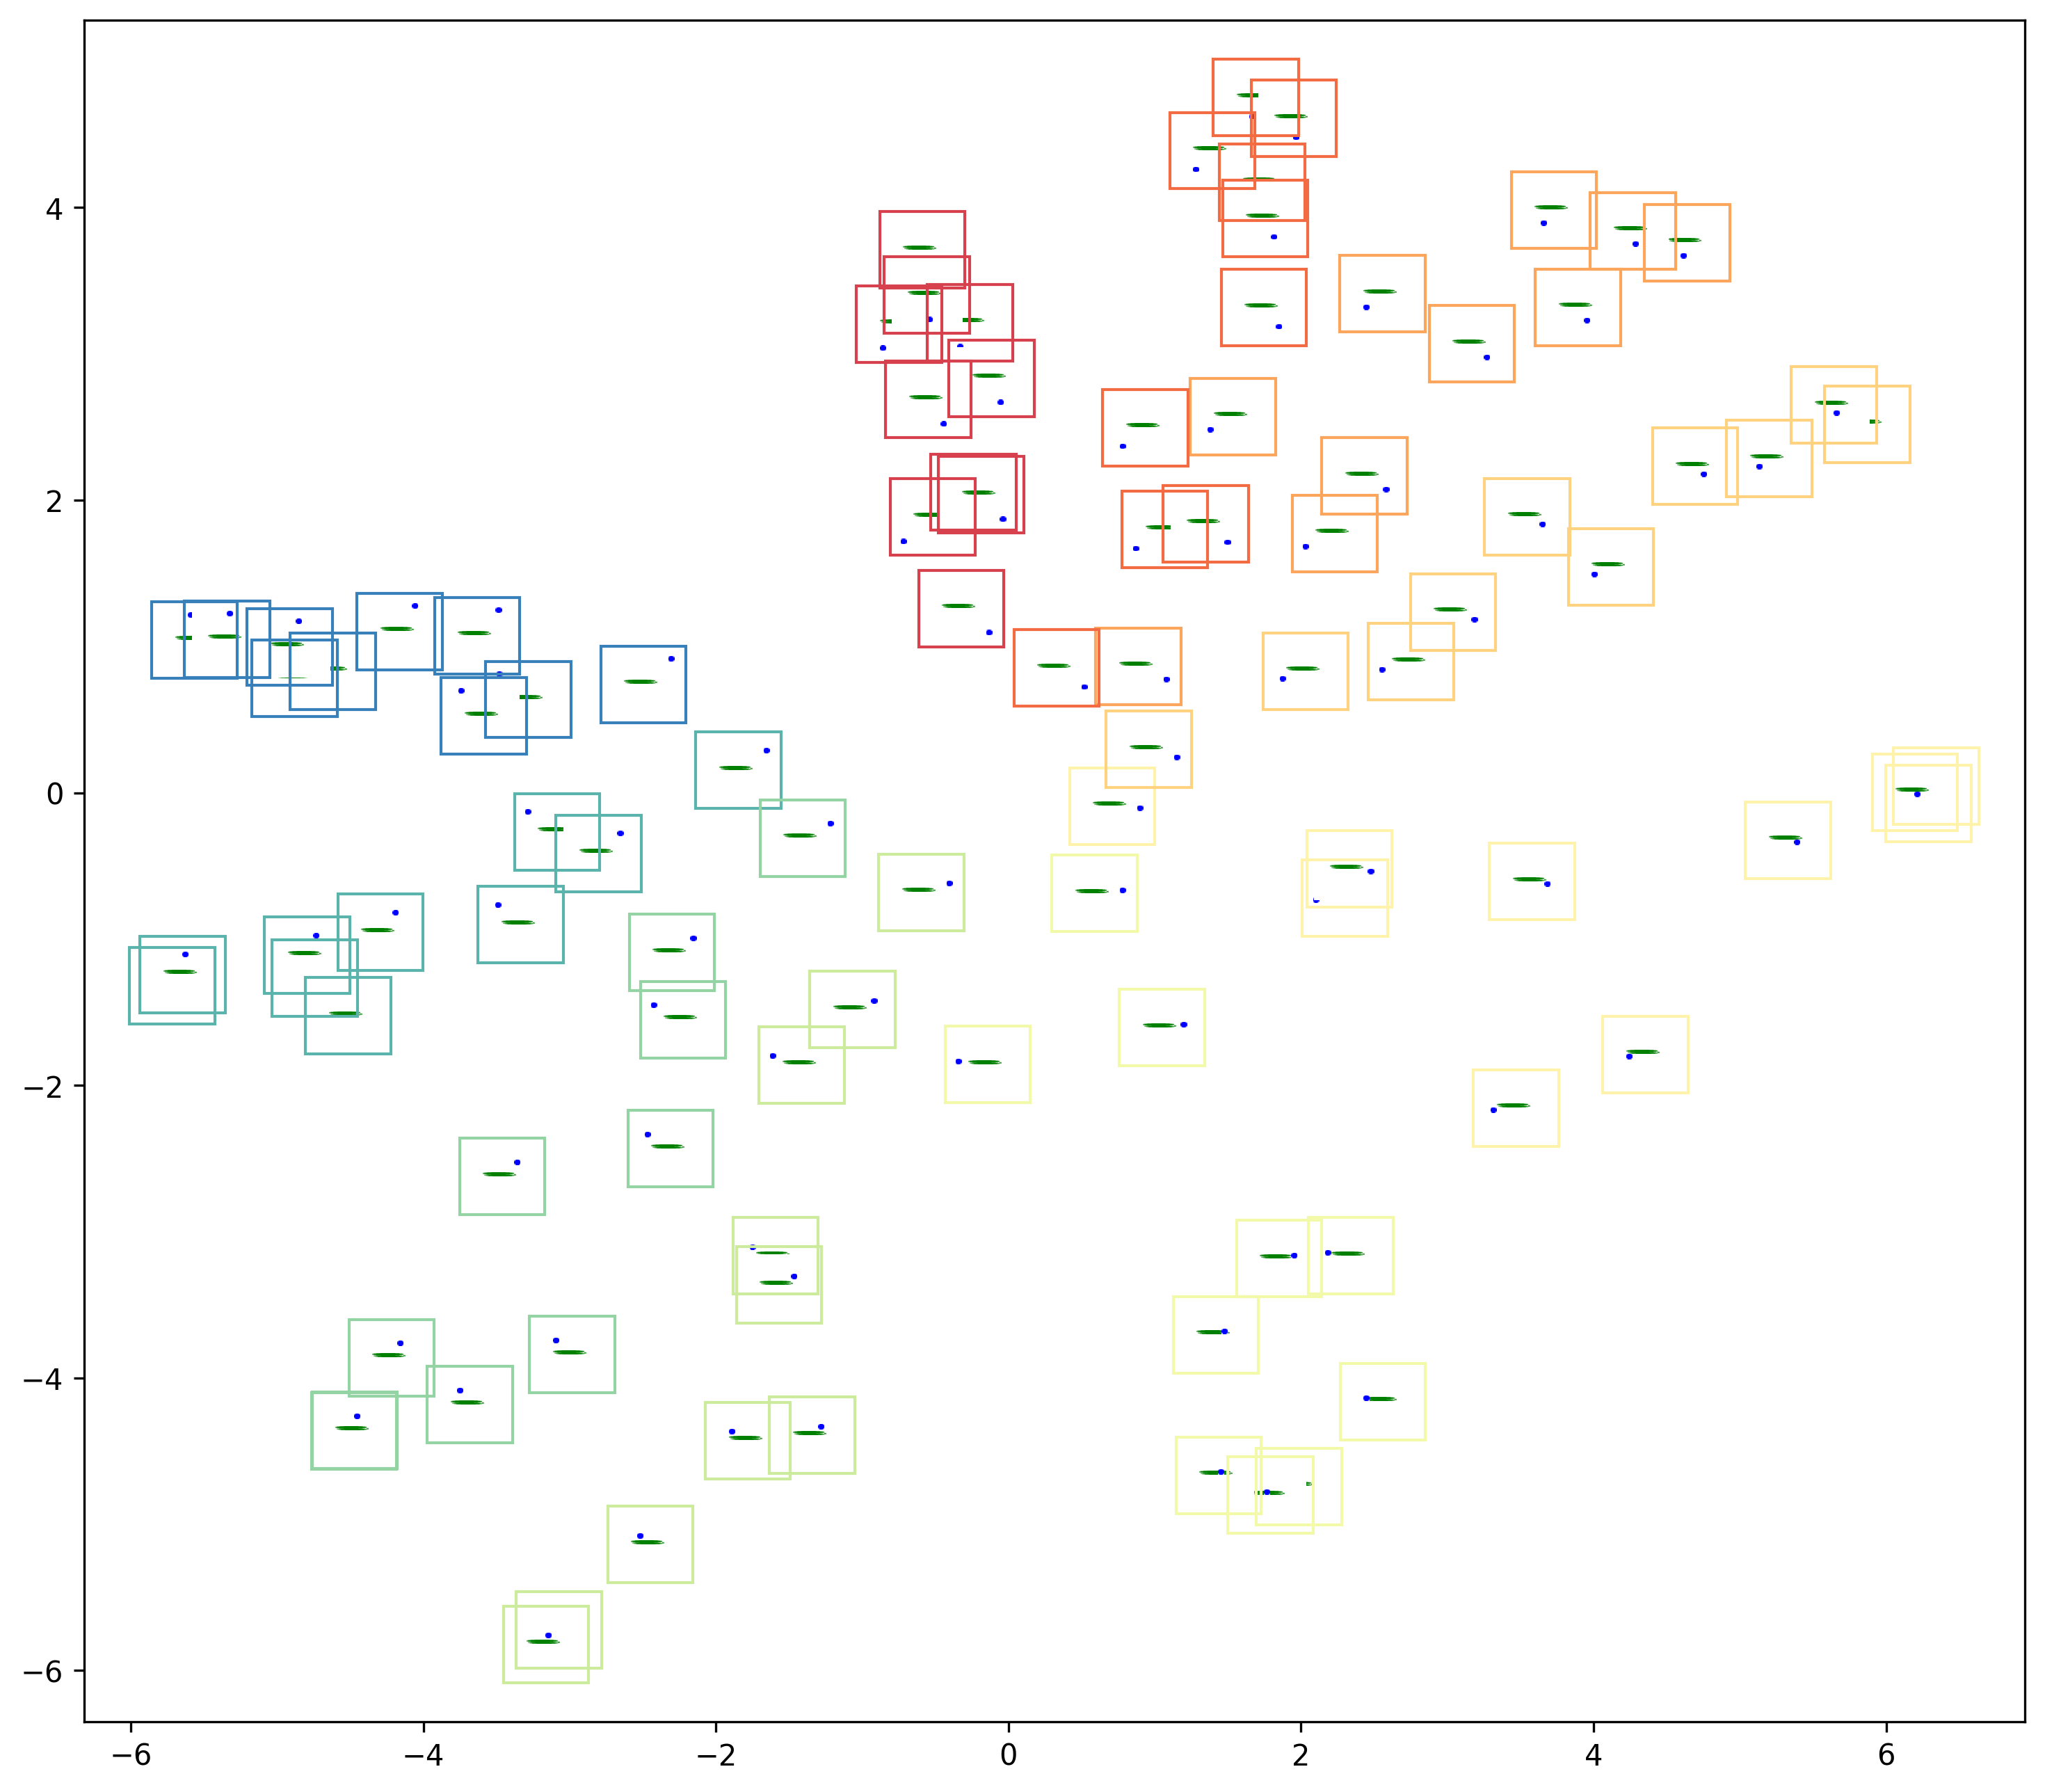

In [22]:
resnet = build_model(RESNET, device, pretrained=True)
analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, target_positions, reference_positions)
analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
# analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, target_positions, 
#                      reference_positions, plot_tsne_func=plot_tsne_quiver)
del resnet

## ImageNet-pretrained vgg

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.0014044667536424885


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.5316326469498818


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.4749435768110642


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.5016968906980852


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

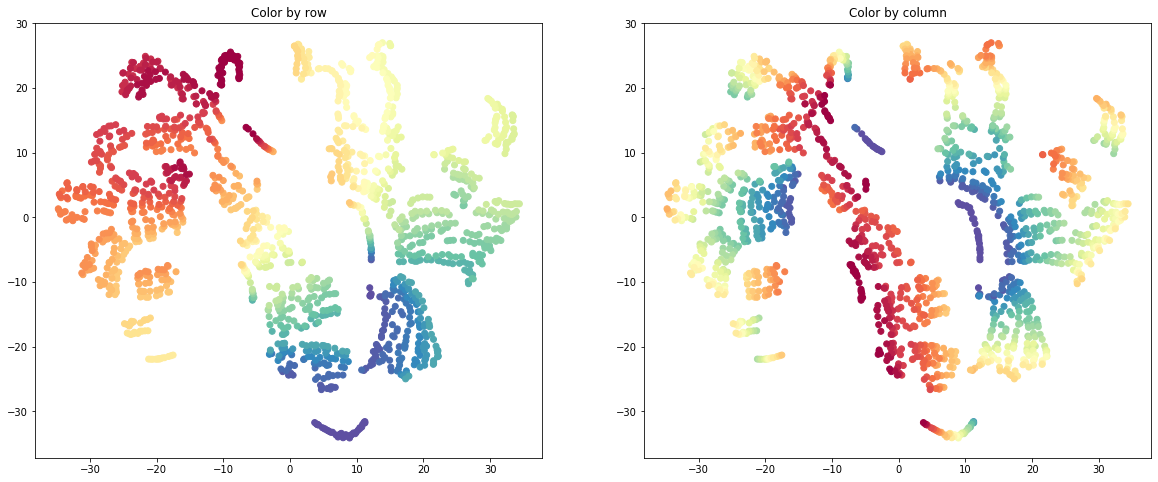

## ImageNet-pretrained vgg

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.04343048323933422


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.5486760520495948


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.475875566276372


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.5282673781780732


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

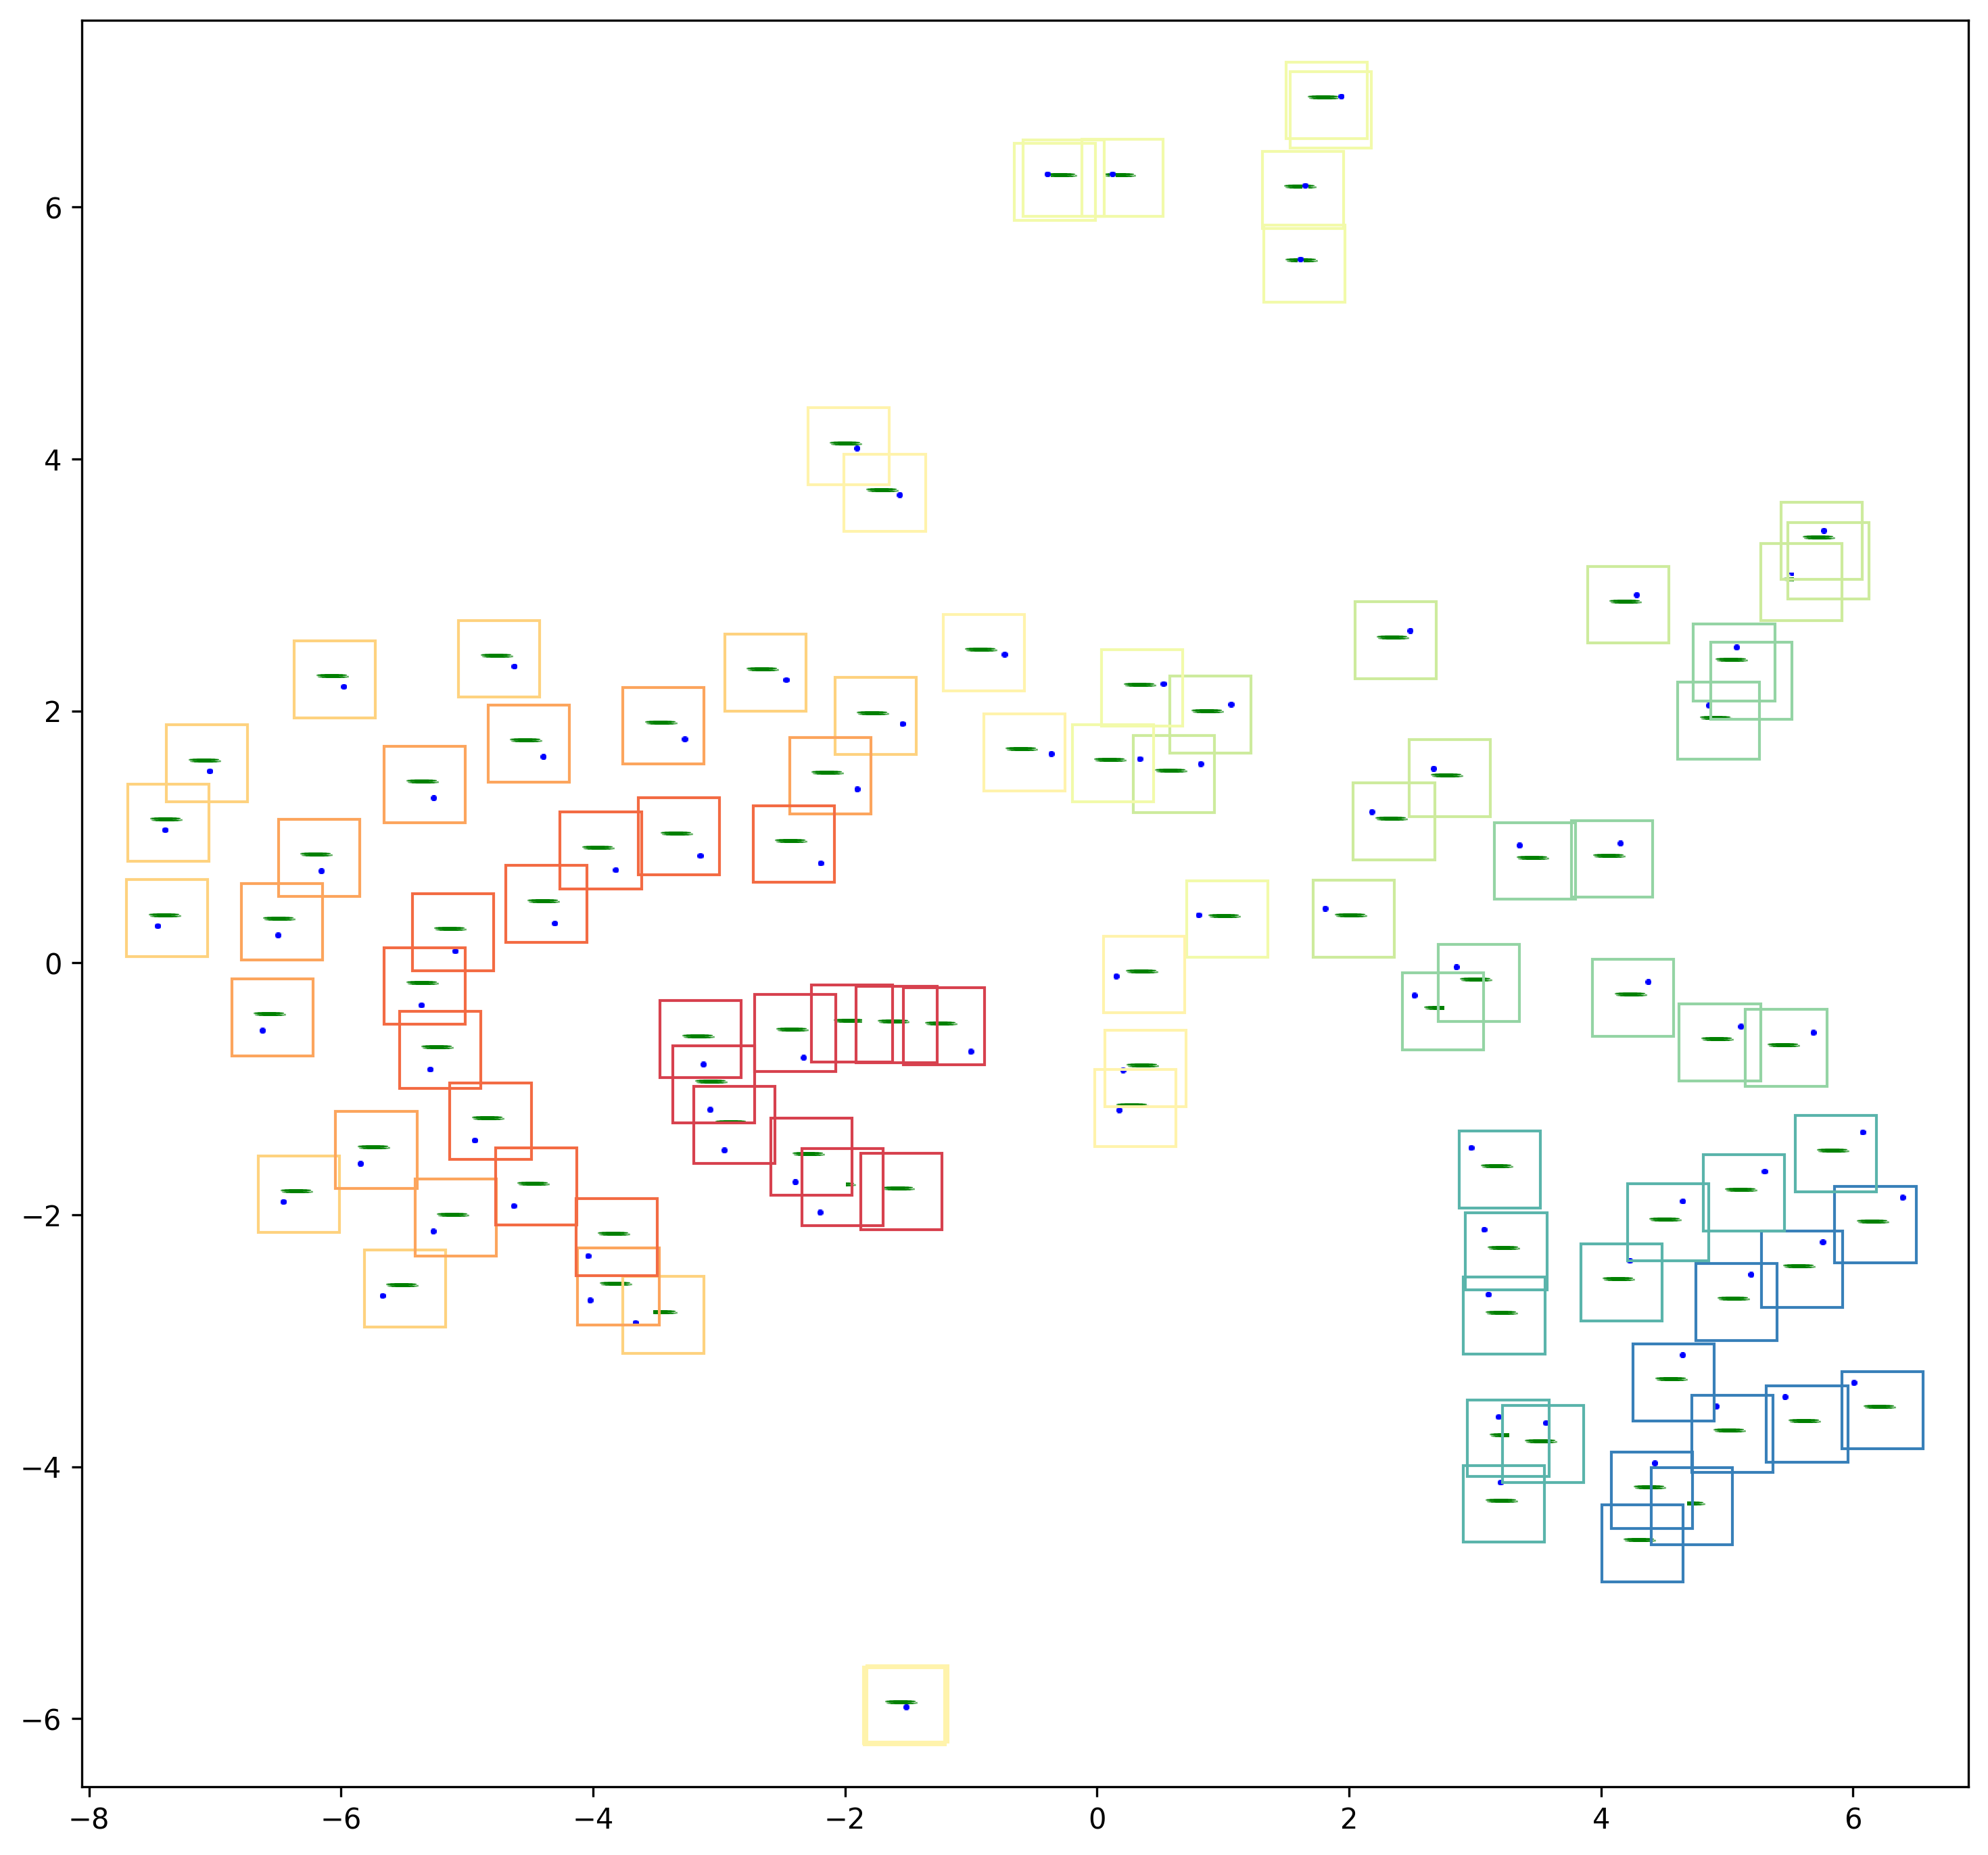

In [23]:
vgg = build_model(VGG, device, pretrained=True)
analyze_single_model('ImageNet-pretrained vgg', vgg, gen, target_positions, reference_positions)
analyze_single_model('ImageNet-pretrained vgg', vgg, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
del vgg

## ImageNet-pretrained mobilenet

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.13506110055540851


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.2762958122138547


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.028894679694297185


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.3133524487502346


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

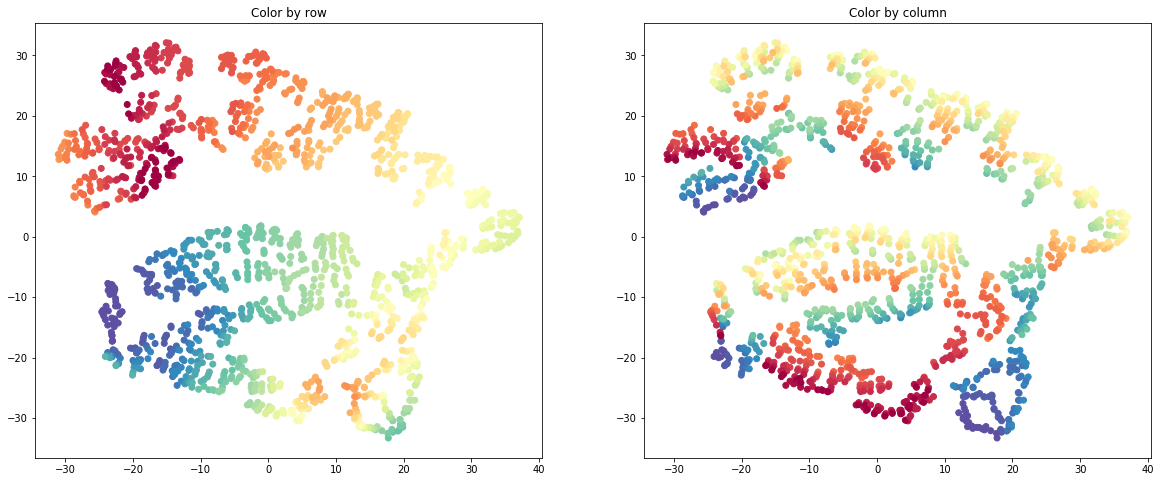

## ImageNet-pretrained mobilenet

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.17777954825967412


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.26578952983973436


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.02110759547435089


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.40823676656863517


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

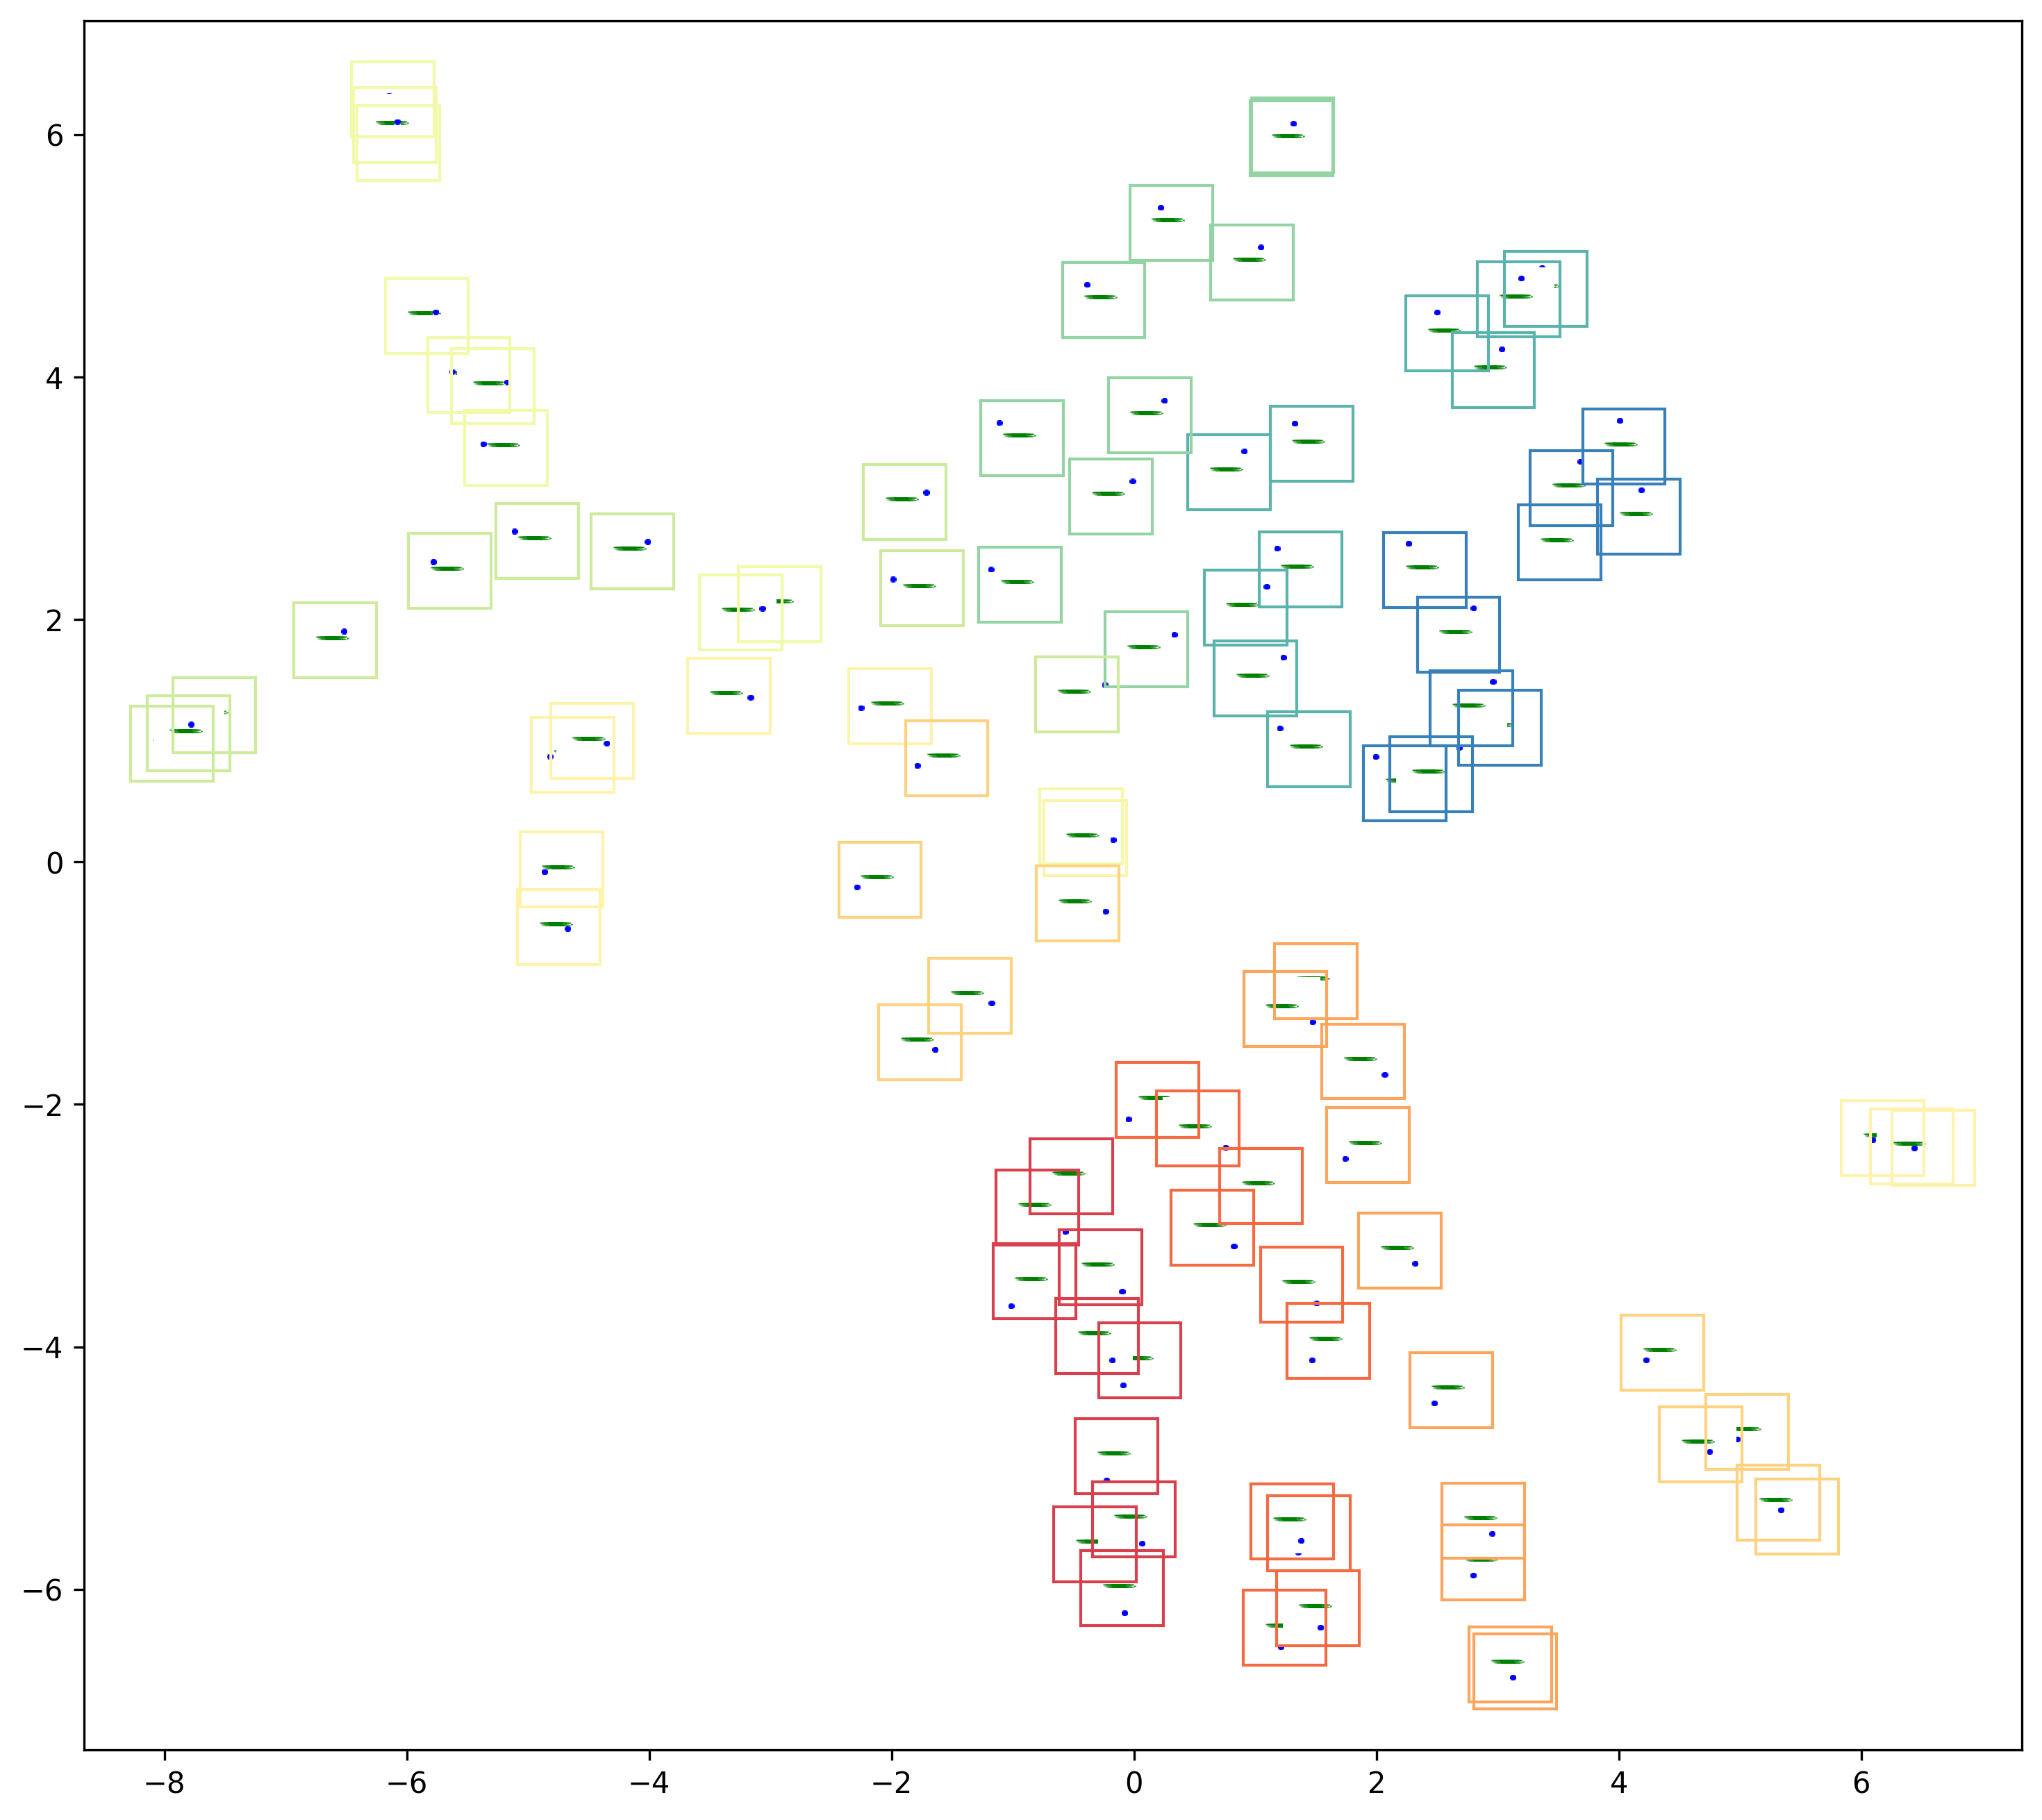

In [24]:
mobilenet = build_model(MOBILENET, device, pretrained=True)
analyze_single_model('ImageNet-pretrained mobilenet', mobilenet, gen, target_positions, reference_positions)
analyze_single_model('ImageNet-pretrained mobilenet', mobilenet, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
del mobilenet

## ImageNet-pretrained resnext50_32x4d

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.10049660782504297


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.33146571192572066


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.16494849273445086


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.5155231132446844


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

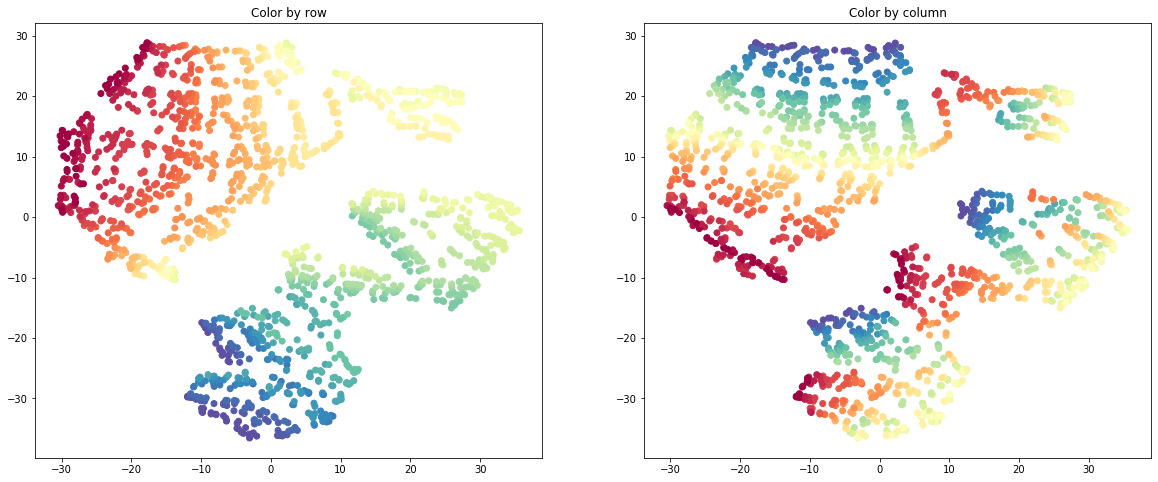

## ImageNet-pretrained resnext50_32x4d

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.09915503413238339


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.3567168276944817


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.17858385335319843


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.41733050628042273


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

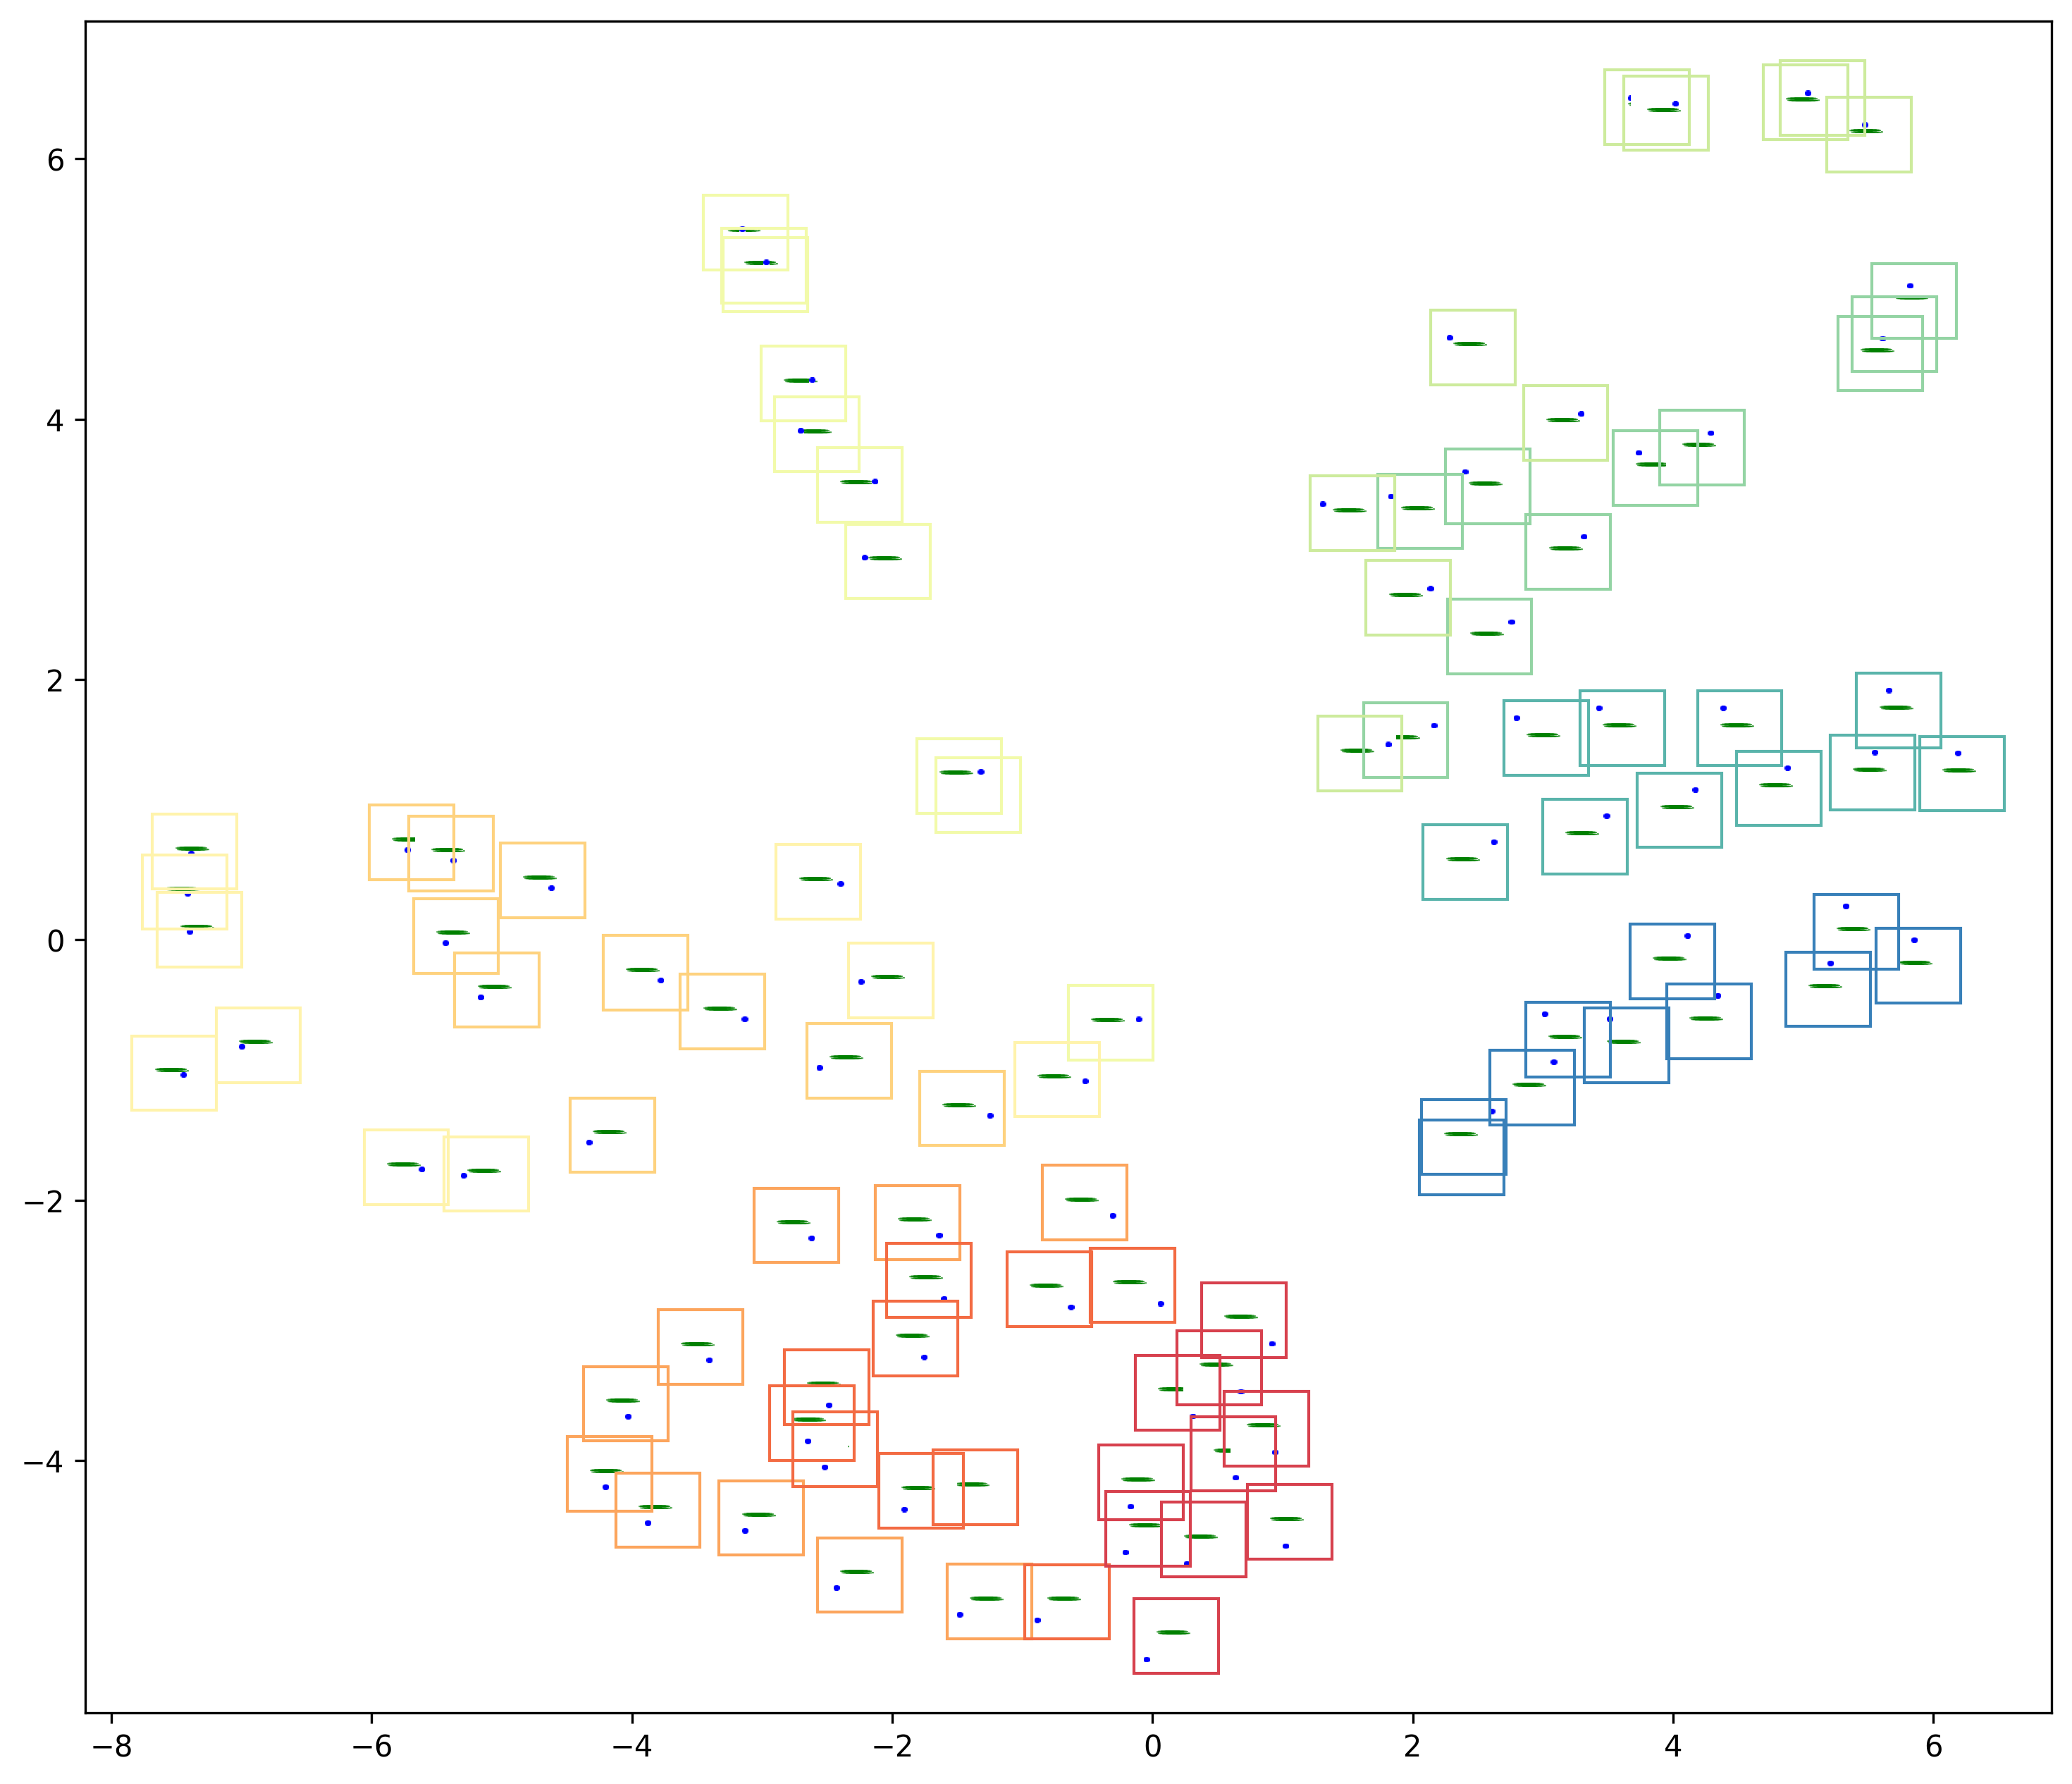

In [25]:
resnext50_32x4d = build_model(RESNEXT, device, pretrained=True)
analyze_single_model('ImageNet-pretrained resnext50_32x4d', resnext50_32x4d, gen, target_positions, reference_positions)
analyze_single_model('ImageNet-pretrained resnext50_32x4d', resnext50_32x4d, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
del resnext50_32x4d

## mobilenet-random-weights

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.007913525310568293


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.3678051046041484


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.1280719609501052


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.3767073049367594


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

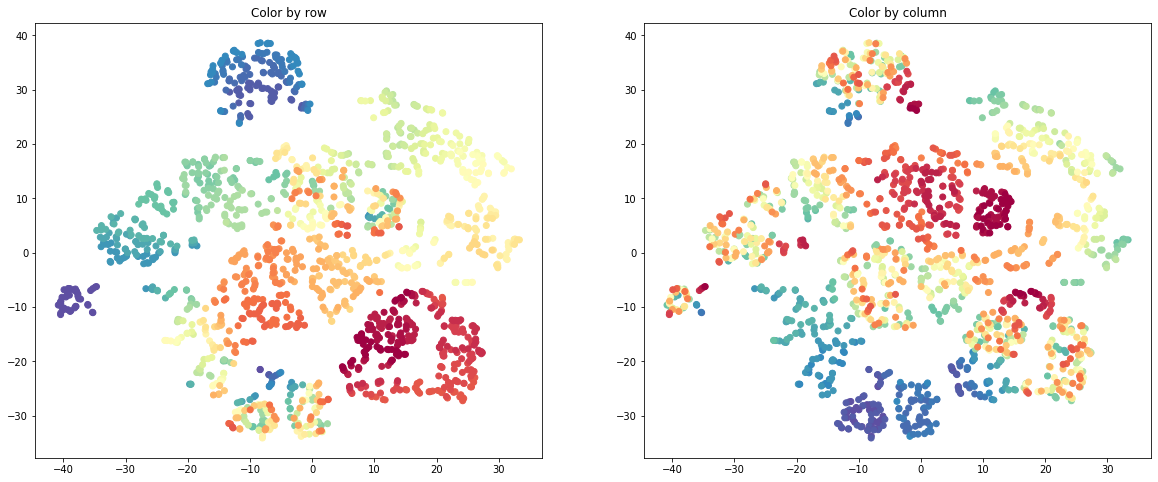

## mobilenet-random-weights

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.16519299106897267


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.3289914311829224


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.124646082341976


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.11629382659441395


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

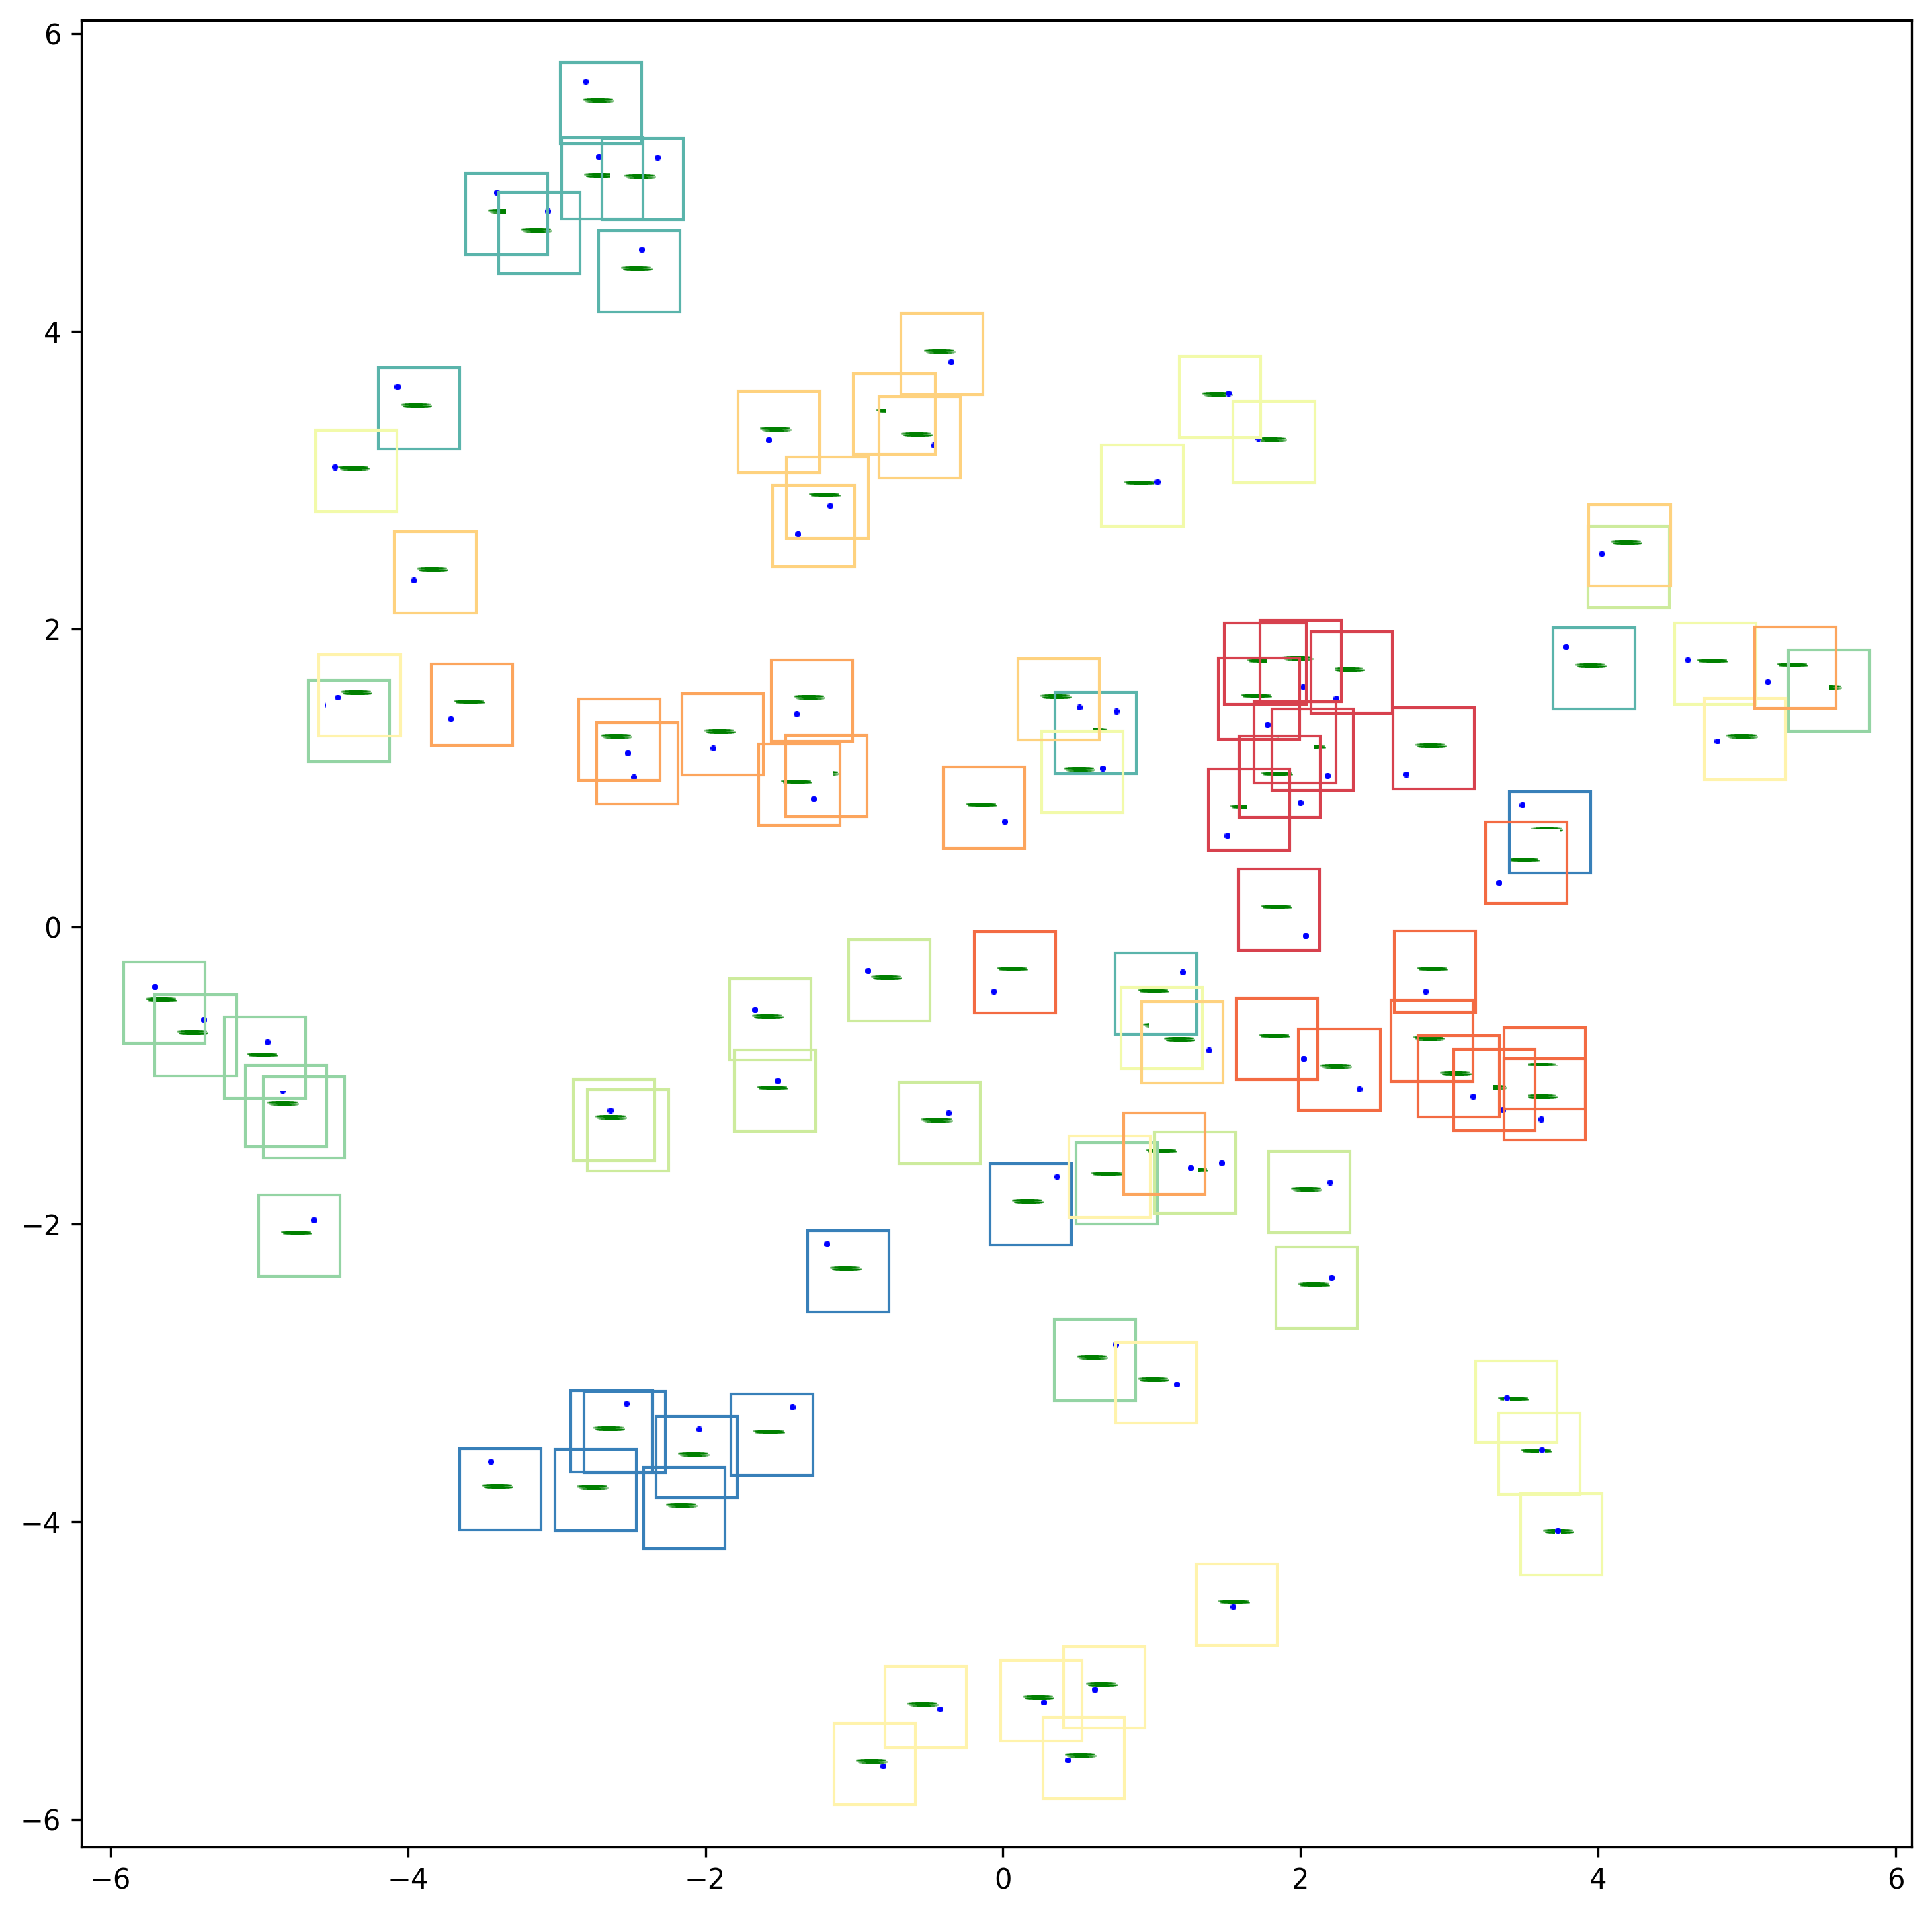

## mobilenet-random-weights

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.16519299106897267


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.3289914311829224


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.124646082341976


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.11629382659441395


------

### t-SNE plots

Border colored by the column (horizontal position) of the target object

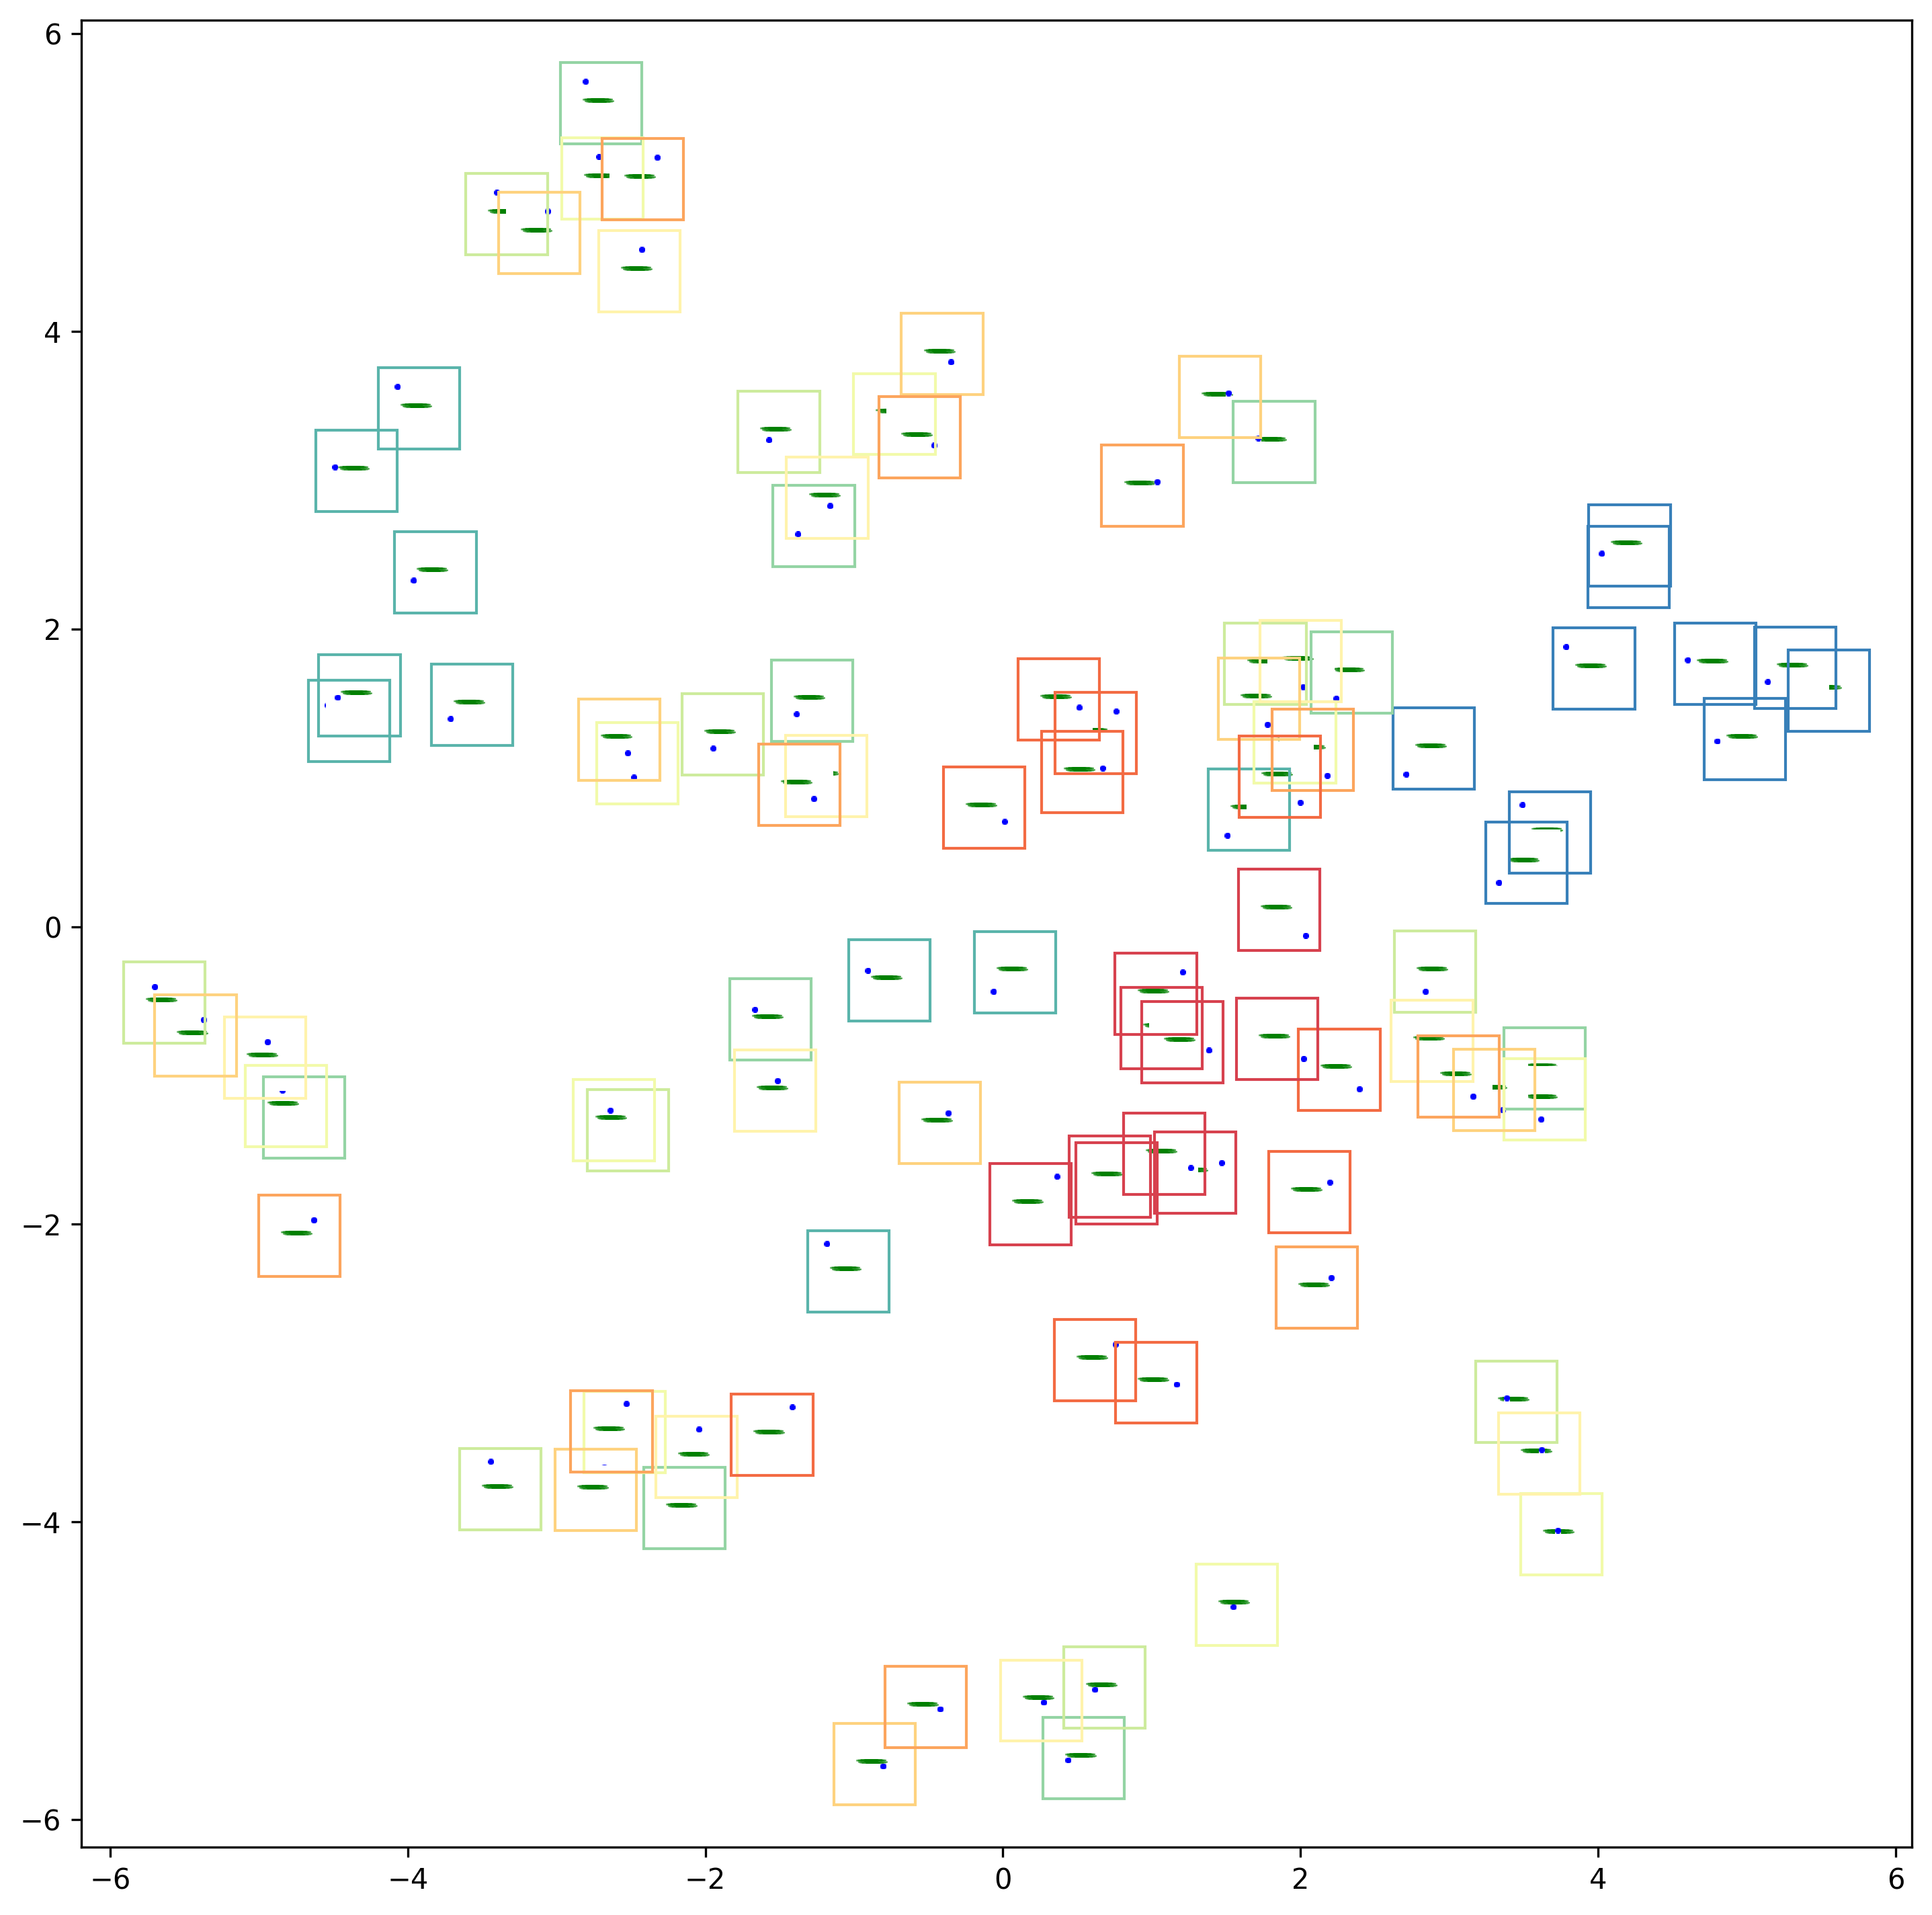

In [26]:
mobilenet_random_weights = build_model(MOBILENET, device, pretrained=False)

analyze_single_model('mobilenet-random-weights', mobilenet_random_weights, gen, target_positions, reference_positions)
analyze_single_model('mobilenet-random-weights', mobilenet_random_weights, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
analyze_single_model('mobilenet-random-weights', mobilenet_random_weights, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='col', figsize=(12, 12), dpi=300))

# analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions,
#                      plot_tsne_func=plot_tsne_quiver)


del mobilenet_random_weights

## TC-SAY-mobilenet

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.5156706235124201


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.7180627697408377


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.630333707136343


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.6966109822522953


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

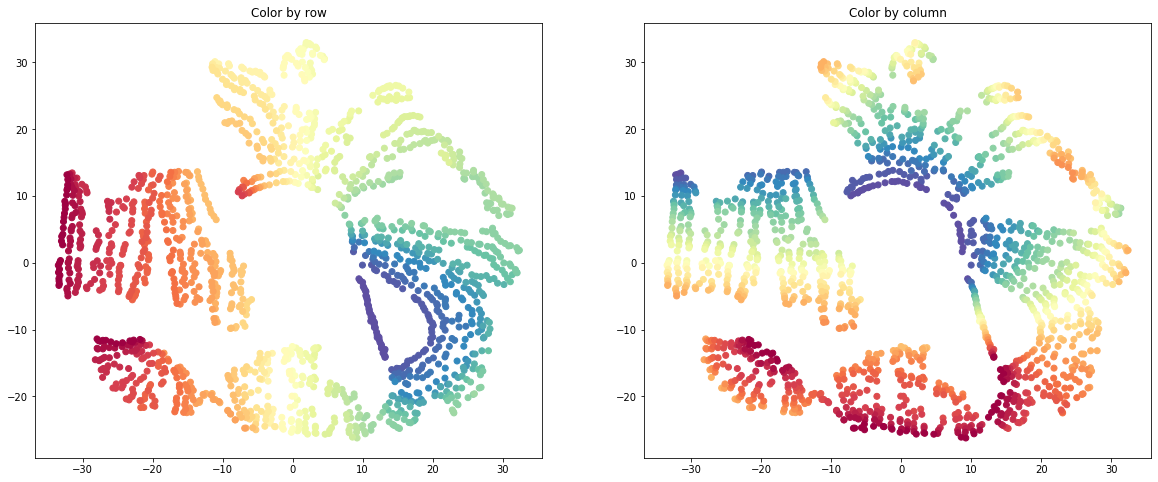

## TC-SAY-mobilenet

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.4962542012572321


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.7154582910767885


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.6197923726571662


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.6811787357594847


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

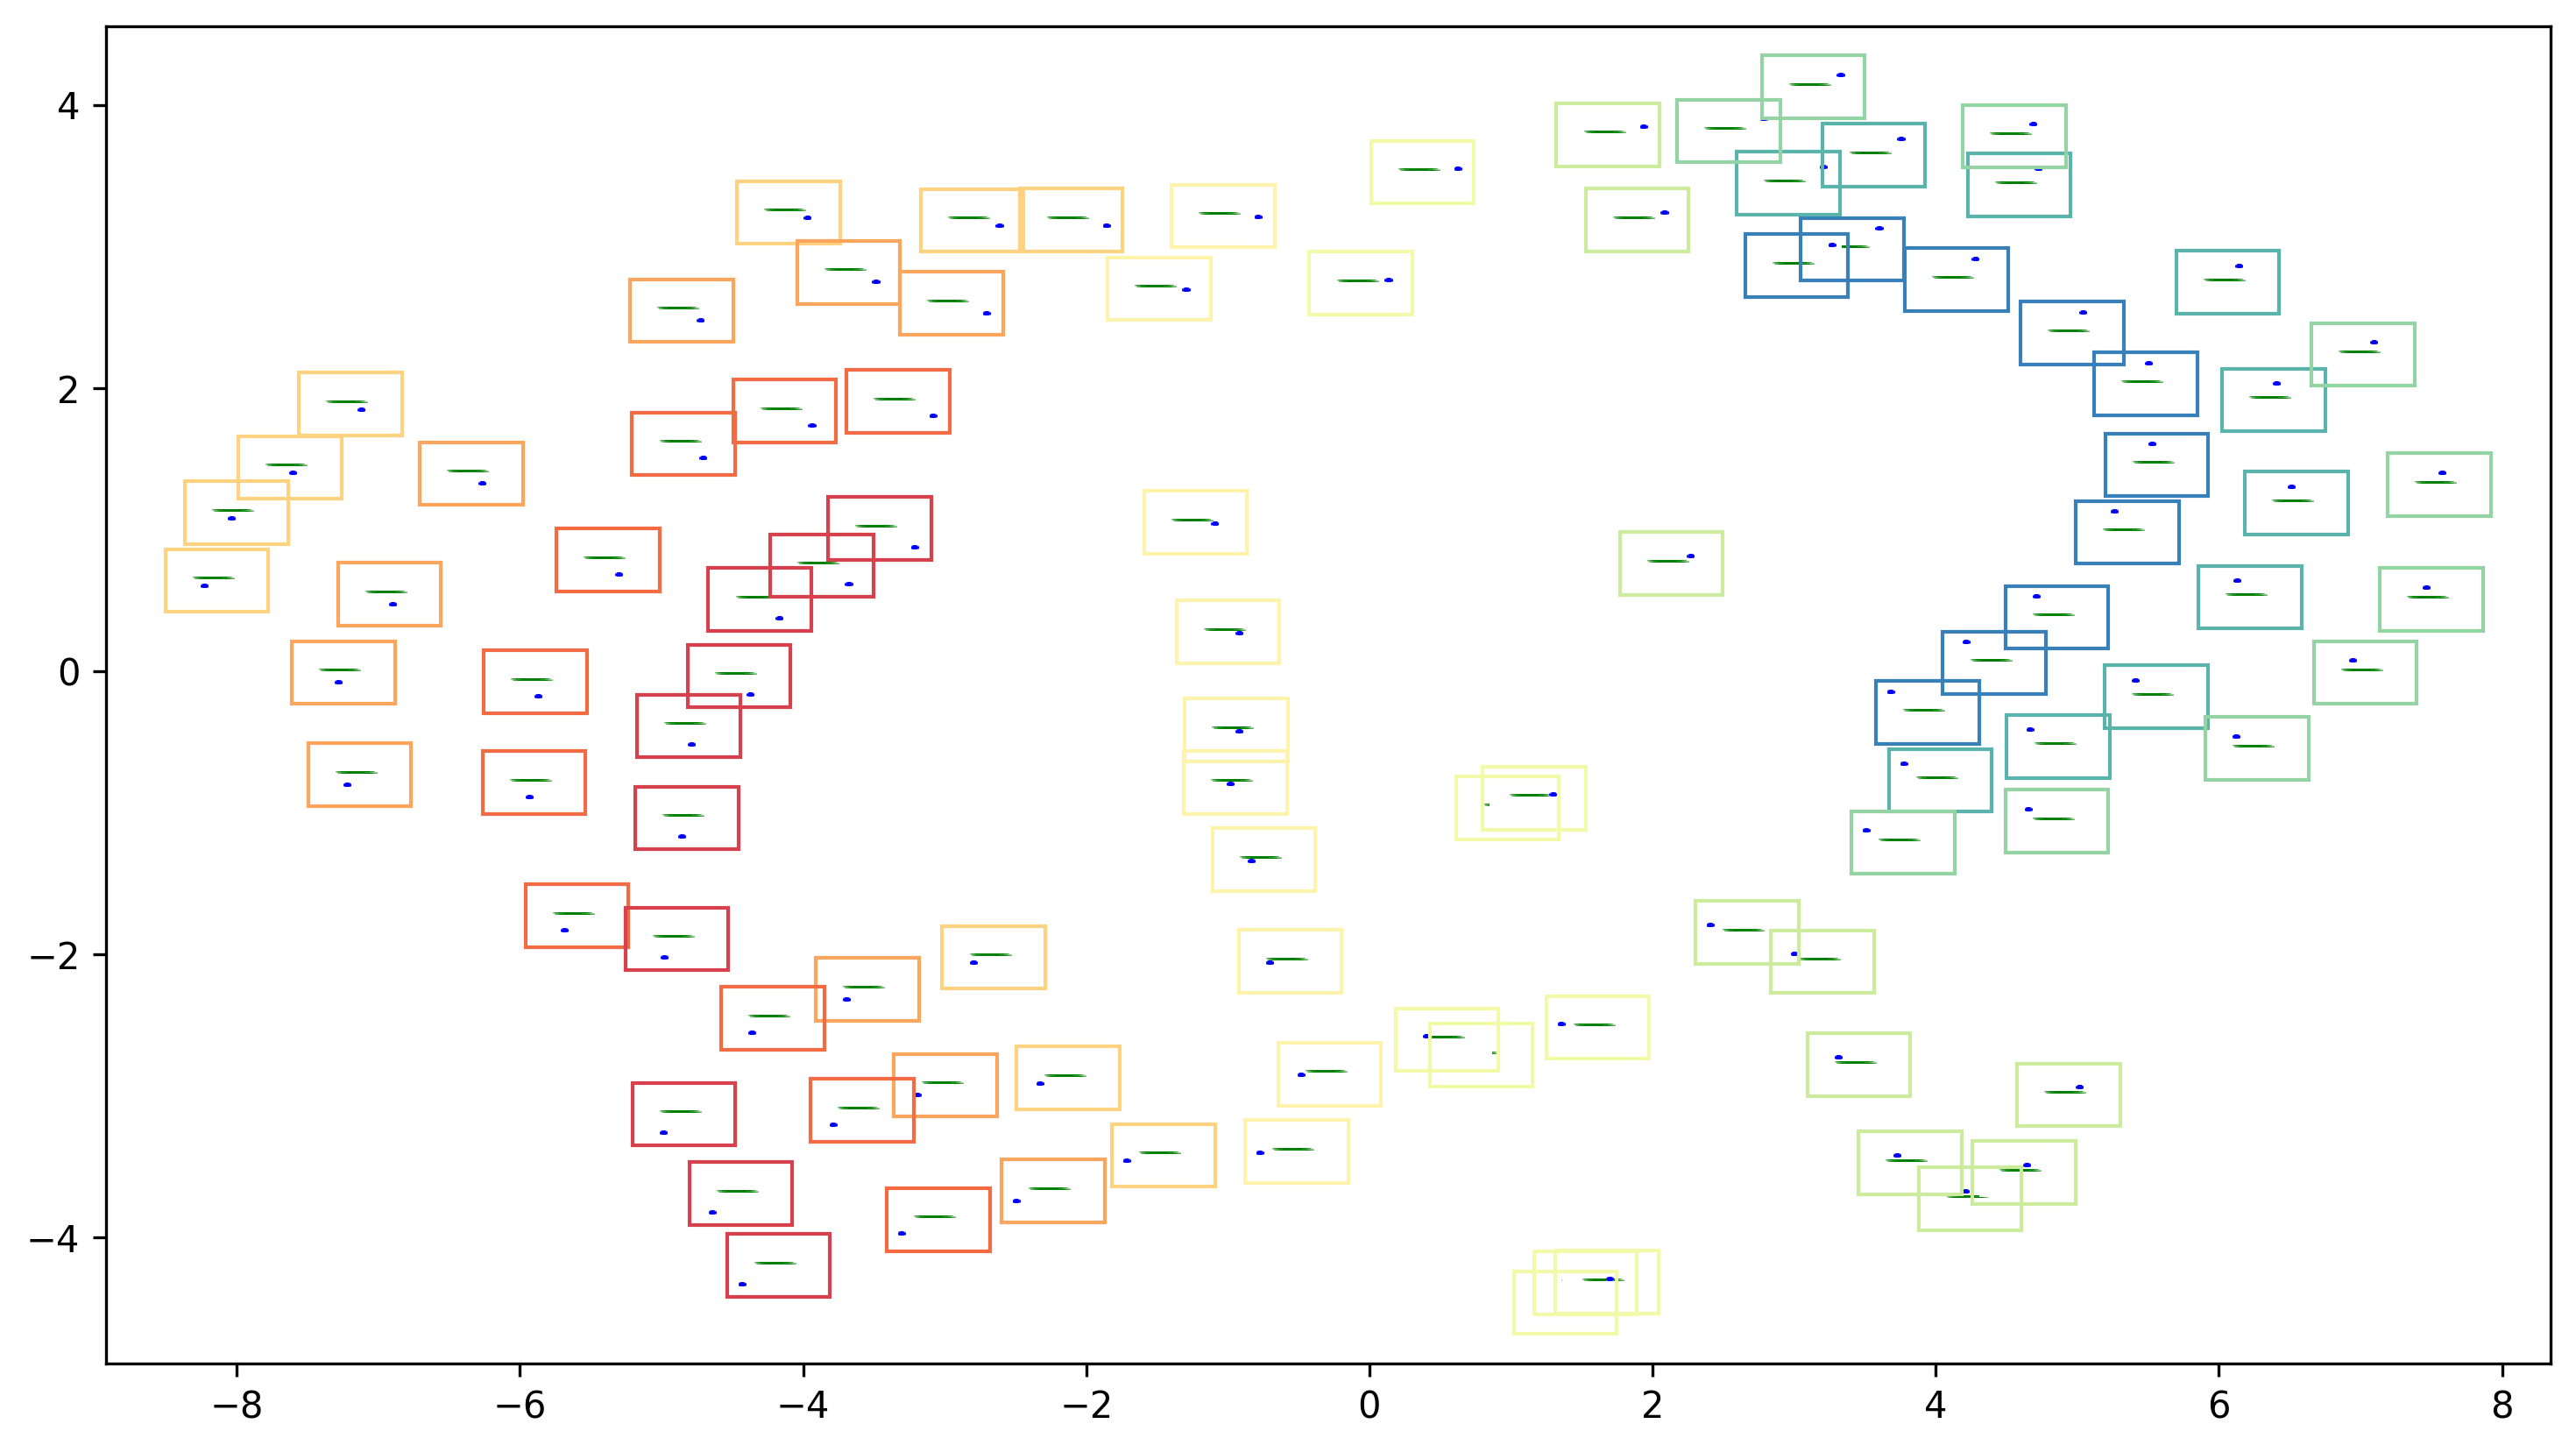

In [27]:
saycam_mobilenet = build_model(MOBILENET, device, pretrained=False, saycam='SAY')

analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions)
analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
# analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions,
#                      plot_tsne_func=plot_tsne_quiver)


del saycam_mobilenet

## TC-S-mobilenet

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.5855771691546684


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.6981152148632469


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.5321332967042864


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.5188468439637128


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

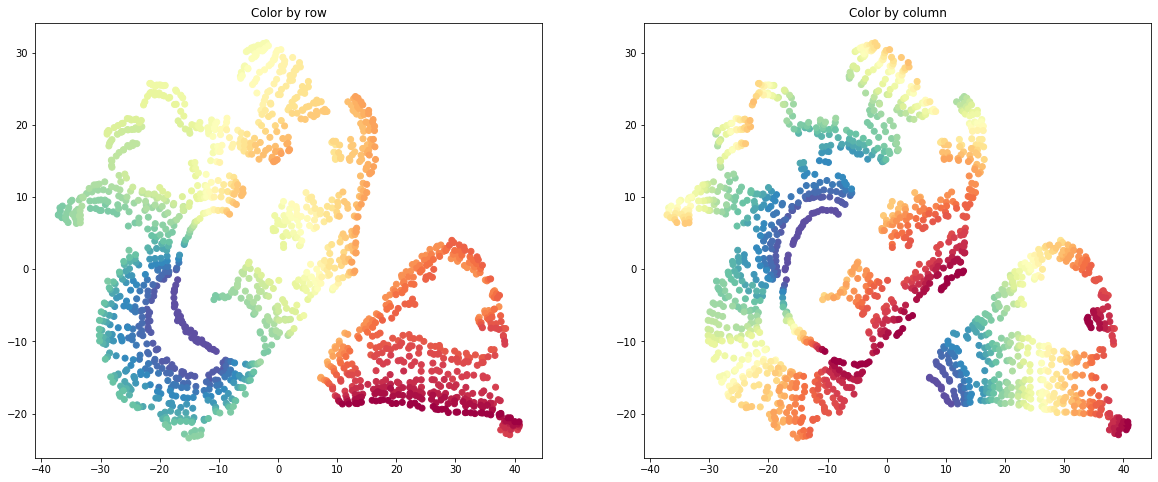

## TC-S-mobilenet

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.5747685528858668


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.6911416011865181


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.5101342423992894


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.6530756593386979


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

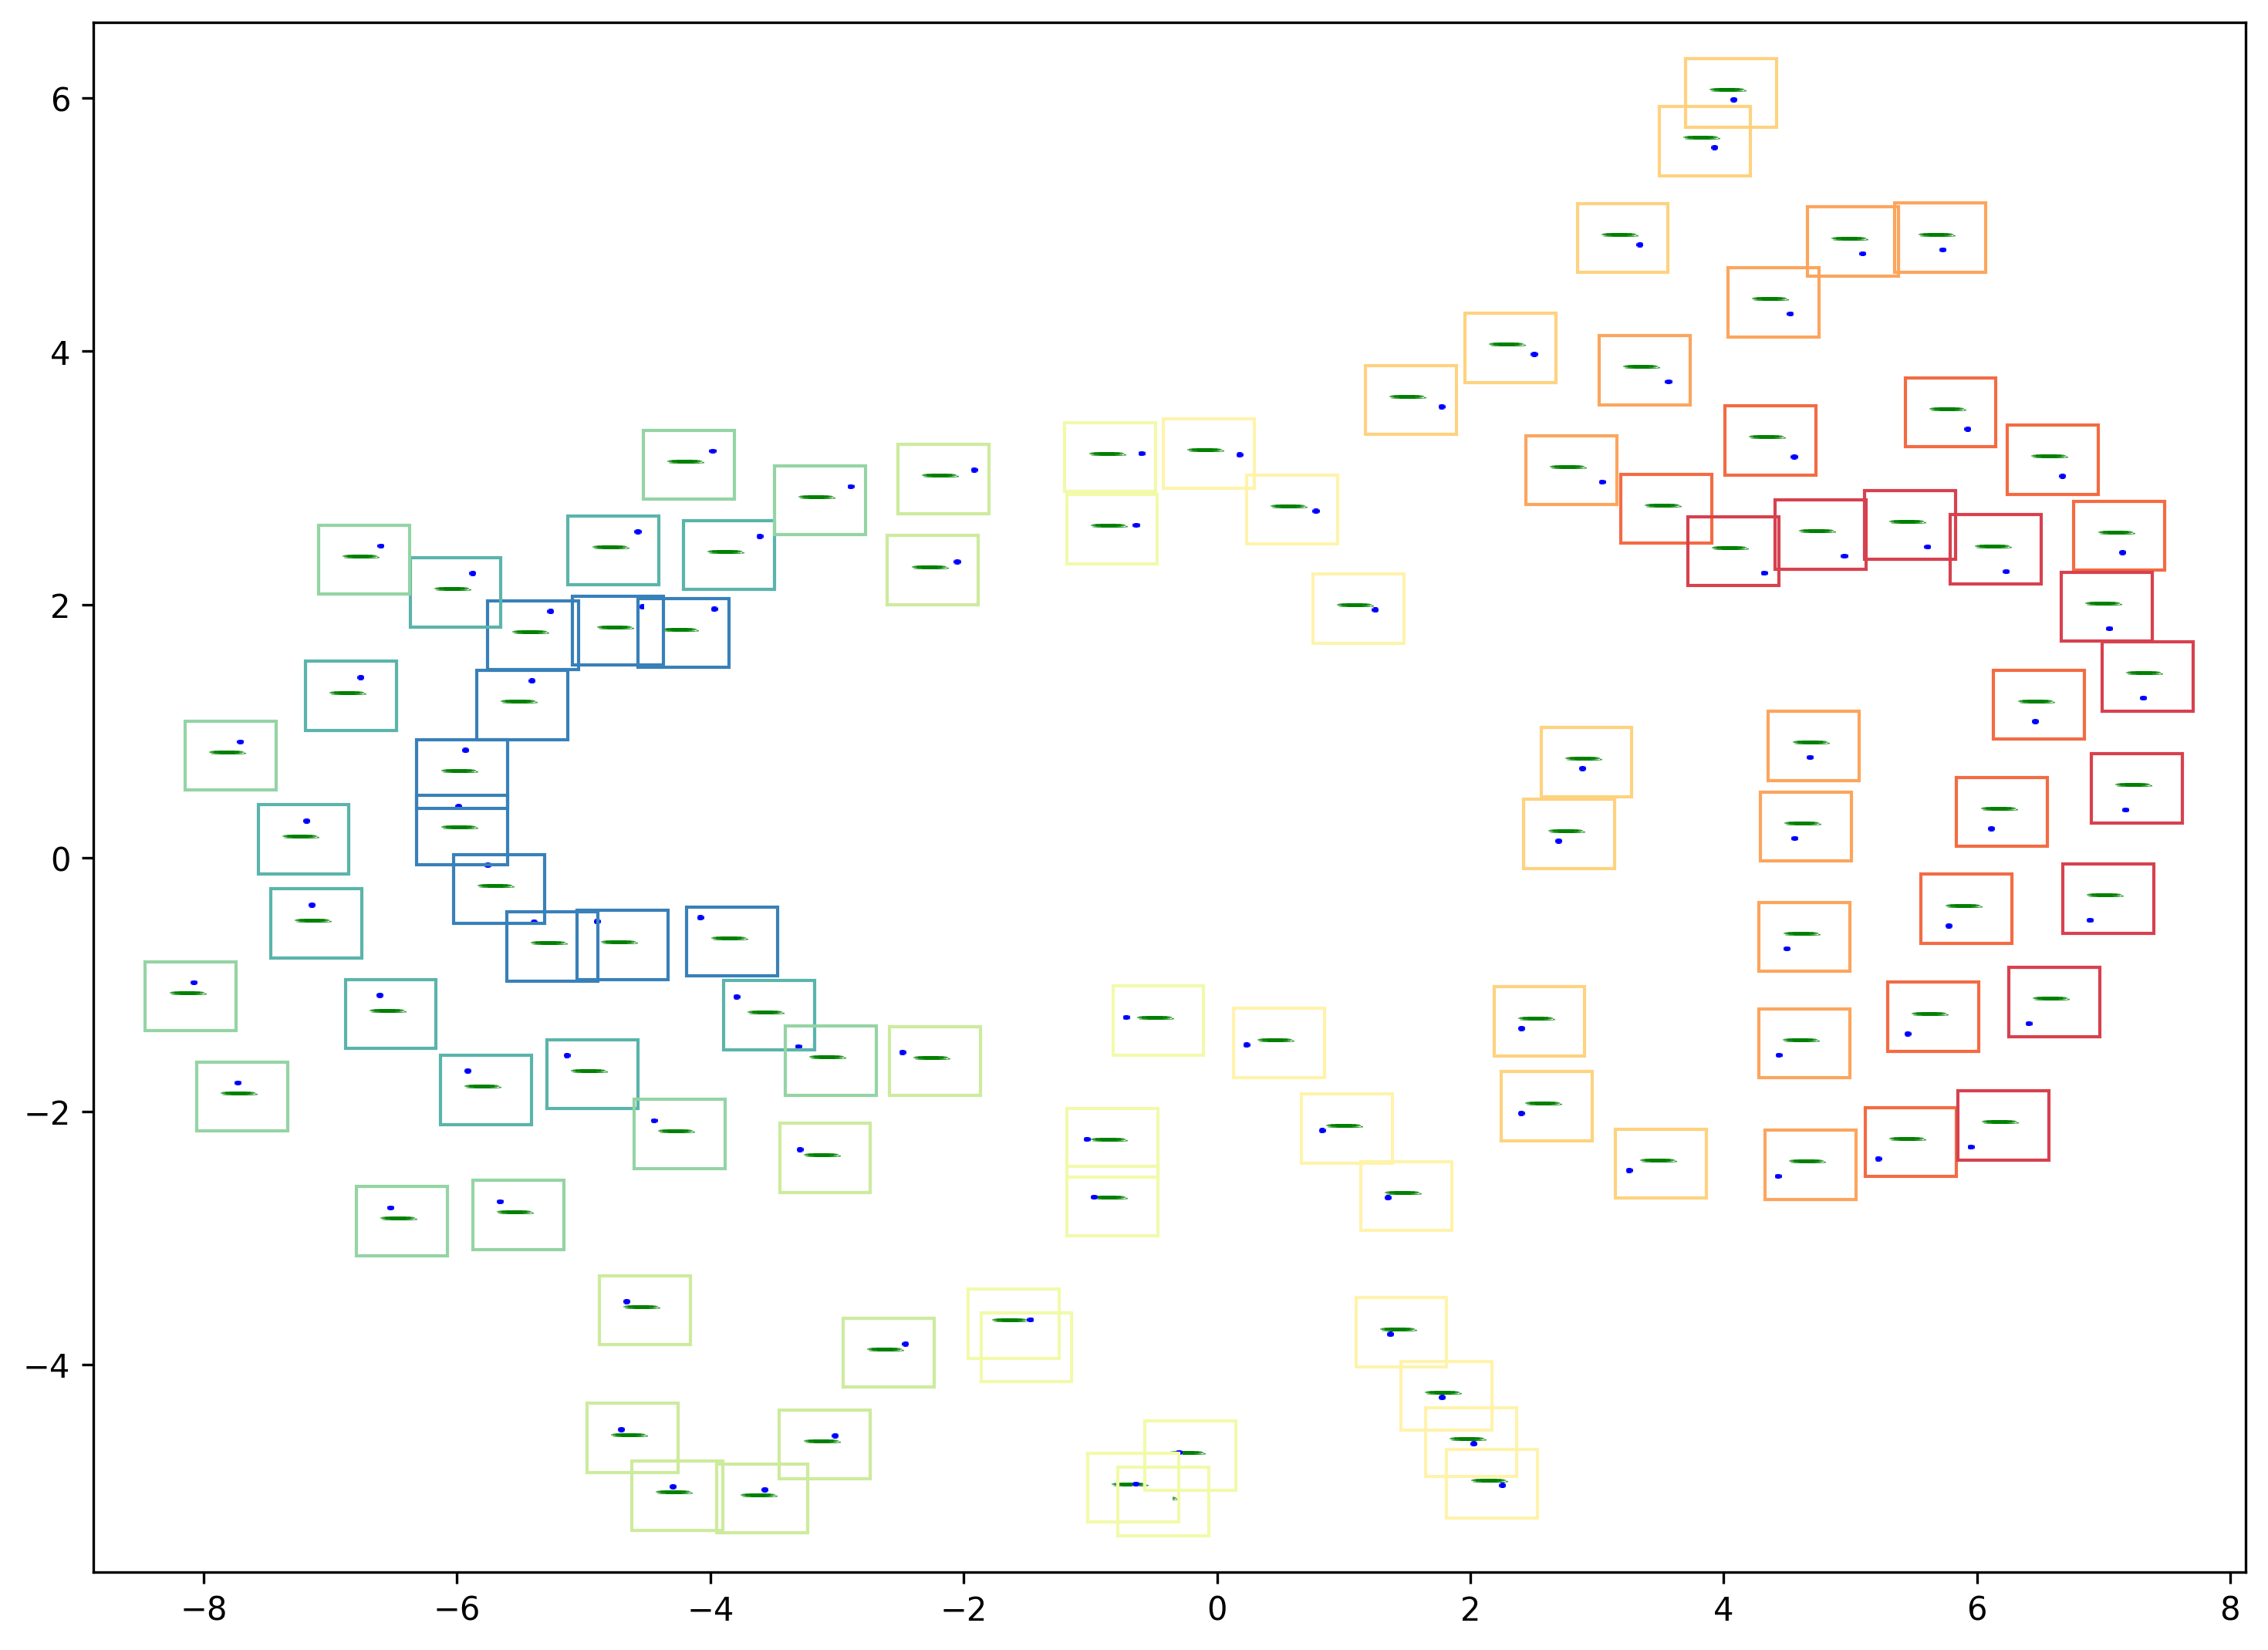

In [28]:
s_mobilenet = build_model(MOBILENET, device, pretrained=False, saycam='S')
analyze_single_model('TC-S-mobilenet', s_mobilenet, gen, target_positions, reference_positions)
analyze_single_model('TC-S-mobilenet', s_mobilenet, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
del s_mobilenet

## TC-SAY-resnext

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.017196655611957143


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.4752977851144011


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.38147366957352985


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.45483213220265206


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

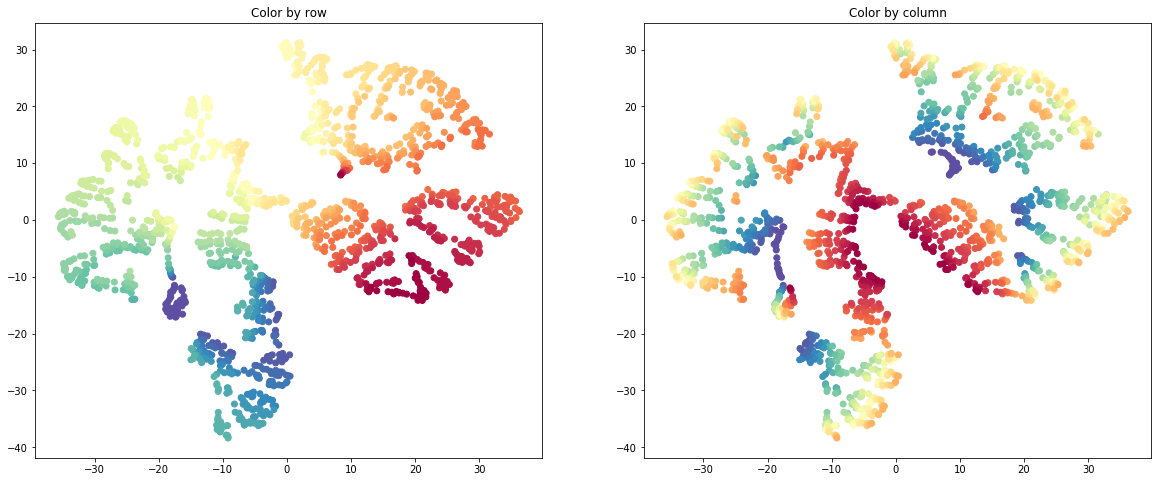

## TC-SAY-resnext

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

0.004666280621084636


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.45363372172099775


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.36049254118401686


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.4934465451645969


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

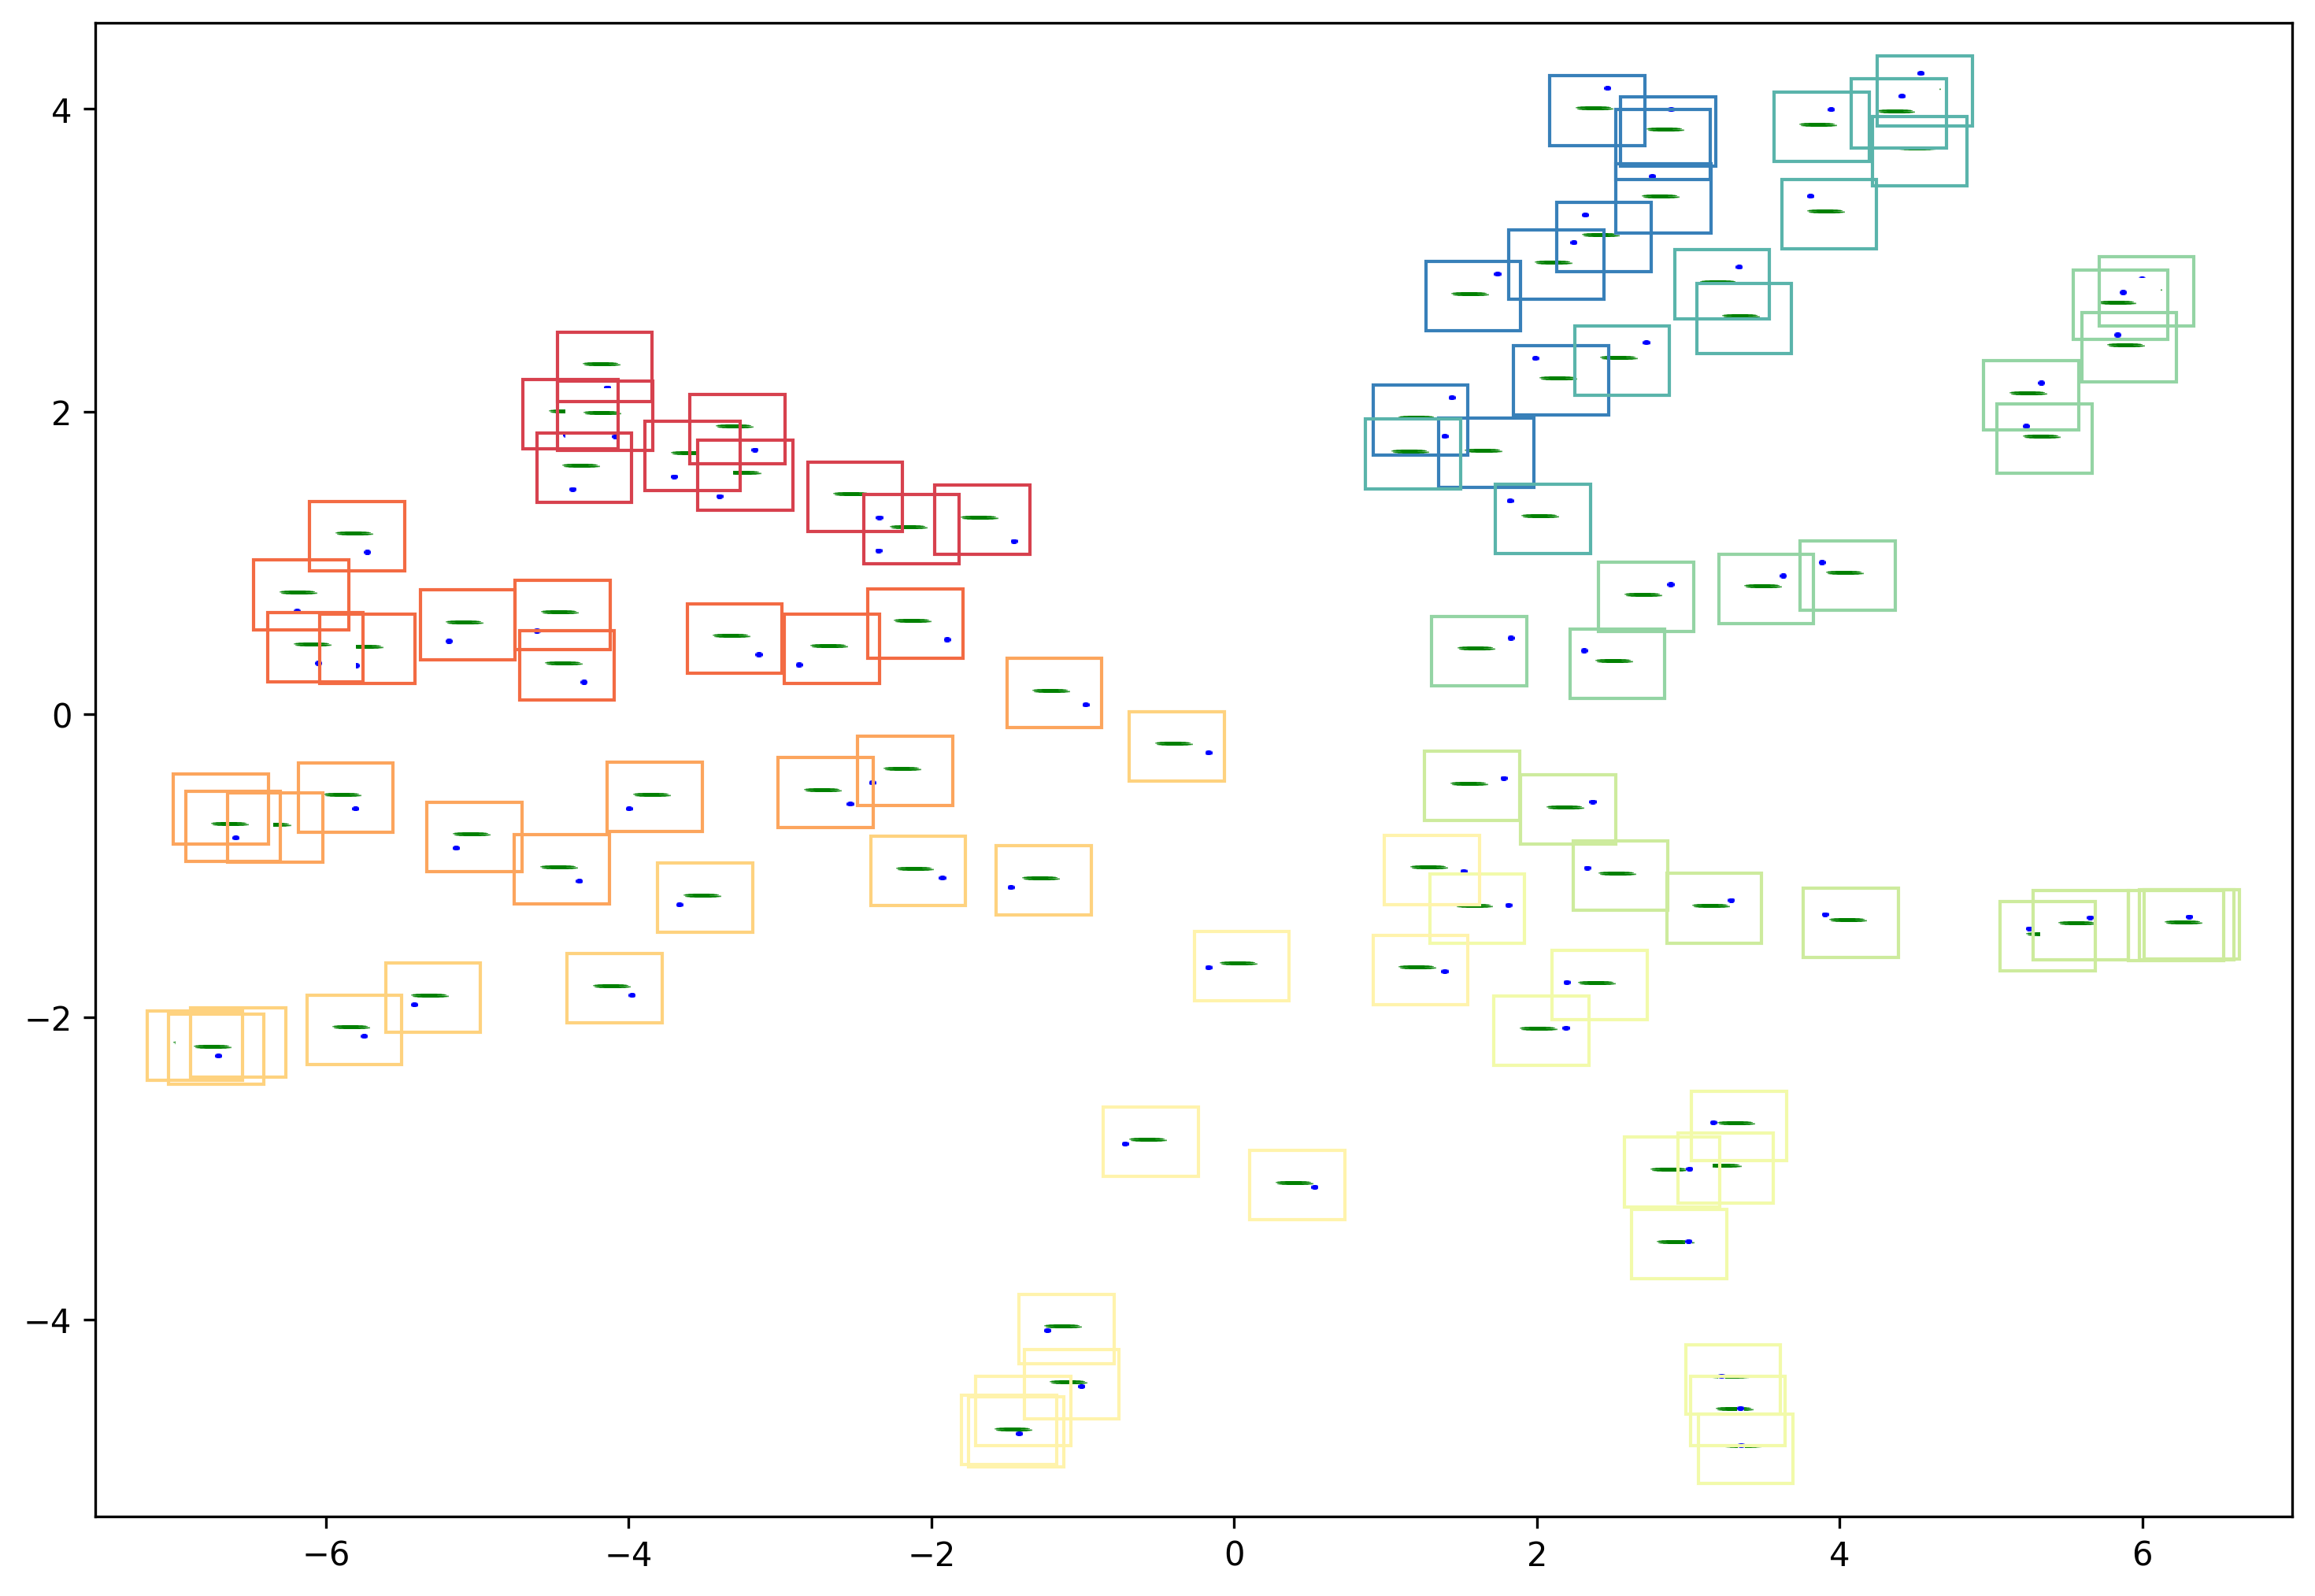

In [29]:
saycam_resnext50_32x4d = build_model(RESNEXT, device, pretrained=False, saycam='SAY')
analyze_single_model('TC-SAY-resnext', saycam_resnext50_32x4d, gen, target_positions, reference_positions)
analyze_single_model('TC-SAY-resnext', saycam_resnext50_32x4d, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
del saycam_resnext50_32x4d

## TC-S-resnext

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.026824783384435655


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.4383794593810363


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.384279384301803


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.4535177684920656


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

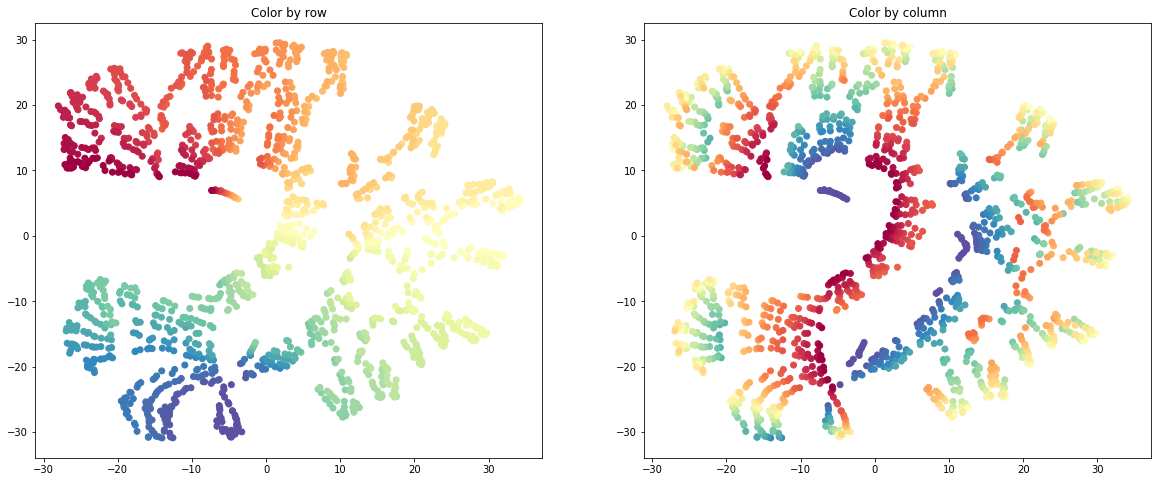

## TC-S-rexnext

### Correlation coefficients:

Correlation coefficient between full embedding cosine to (1 - distance between targets)

-0.049194490424322876


Correlation coefficient between 16-D PCA cosine to (1 - distance between targets)

0.4089059301778993


Correlation coefficient between 2-D PCA cosine to (1 - distance between targets)

0.3571341561531266


Correlation coefficient between t-SNE cosine to (1 - distance between targets)

0.470245466869574


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

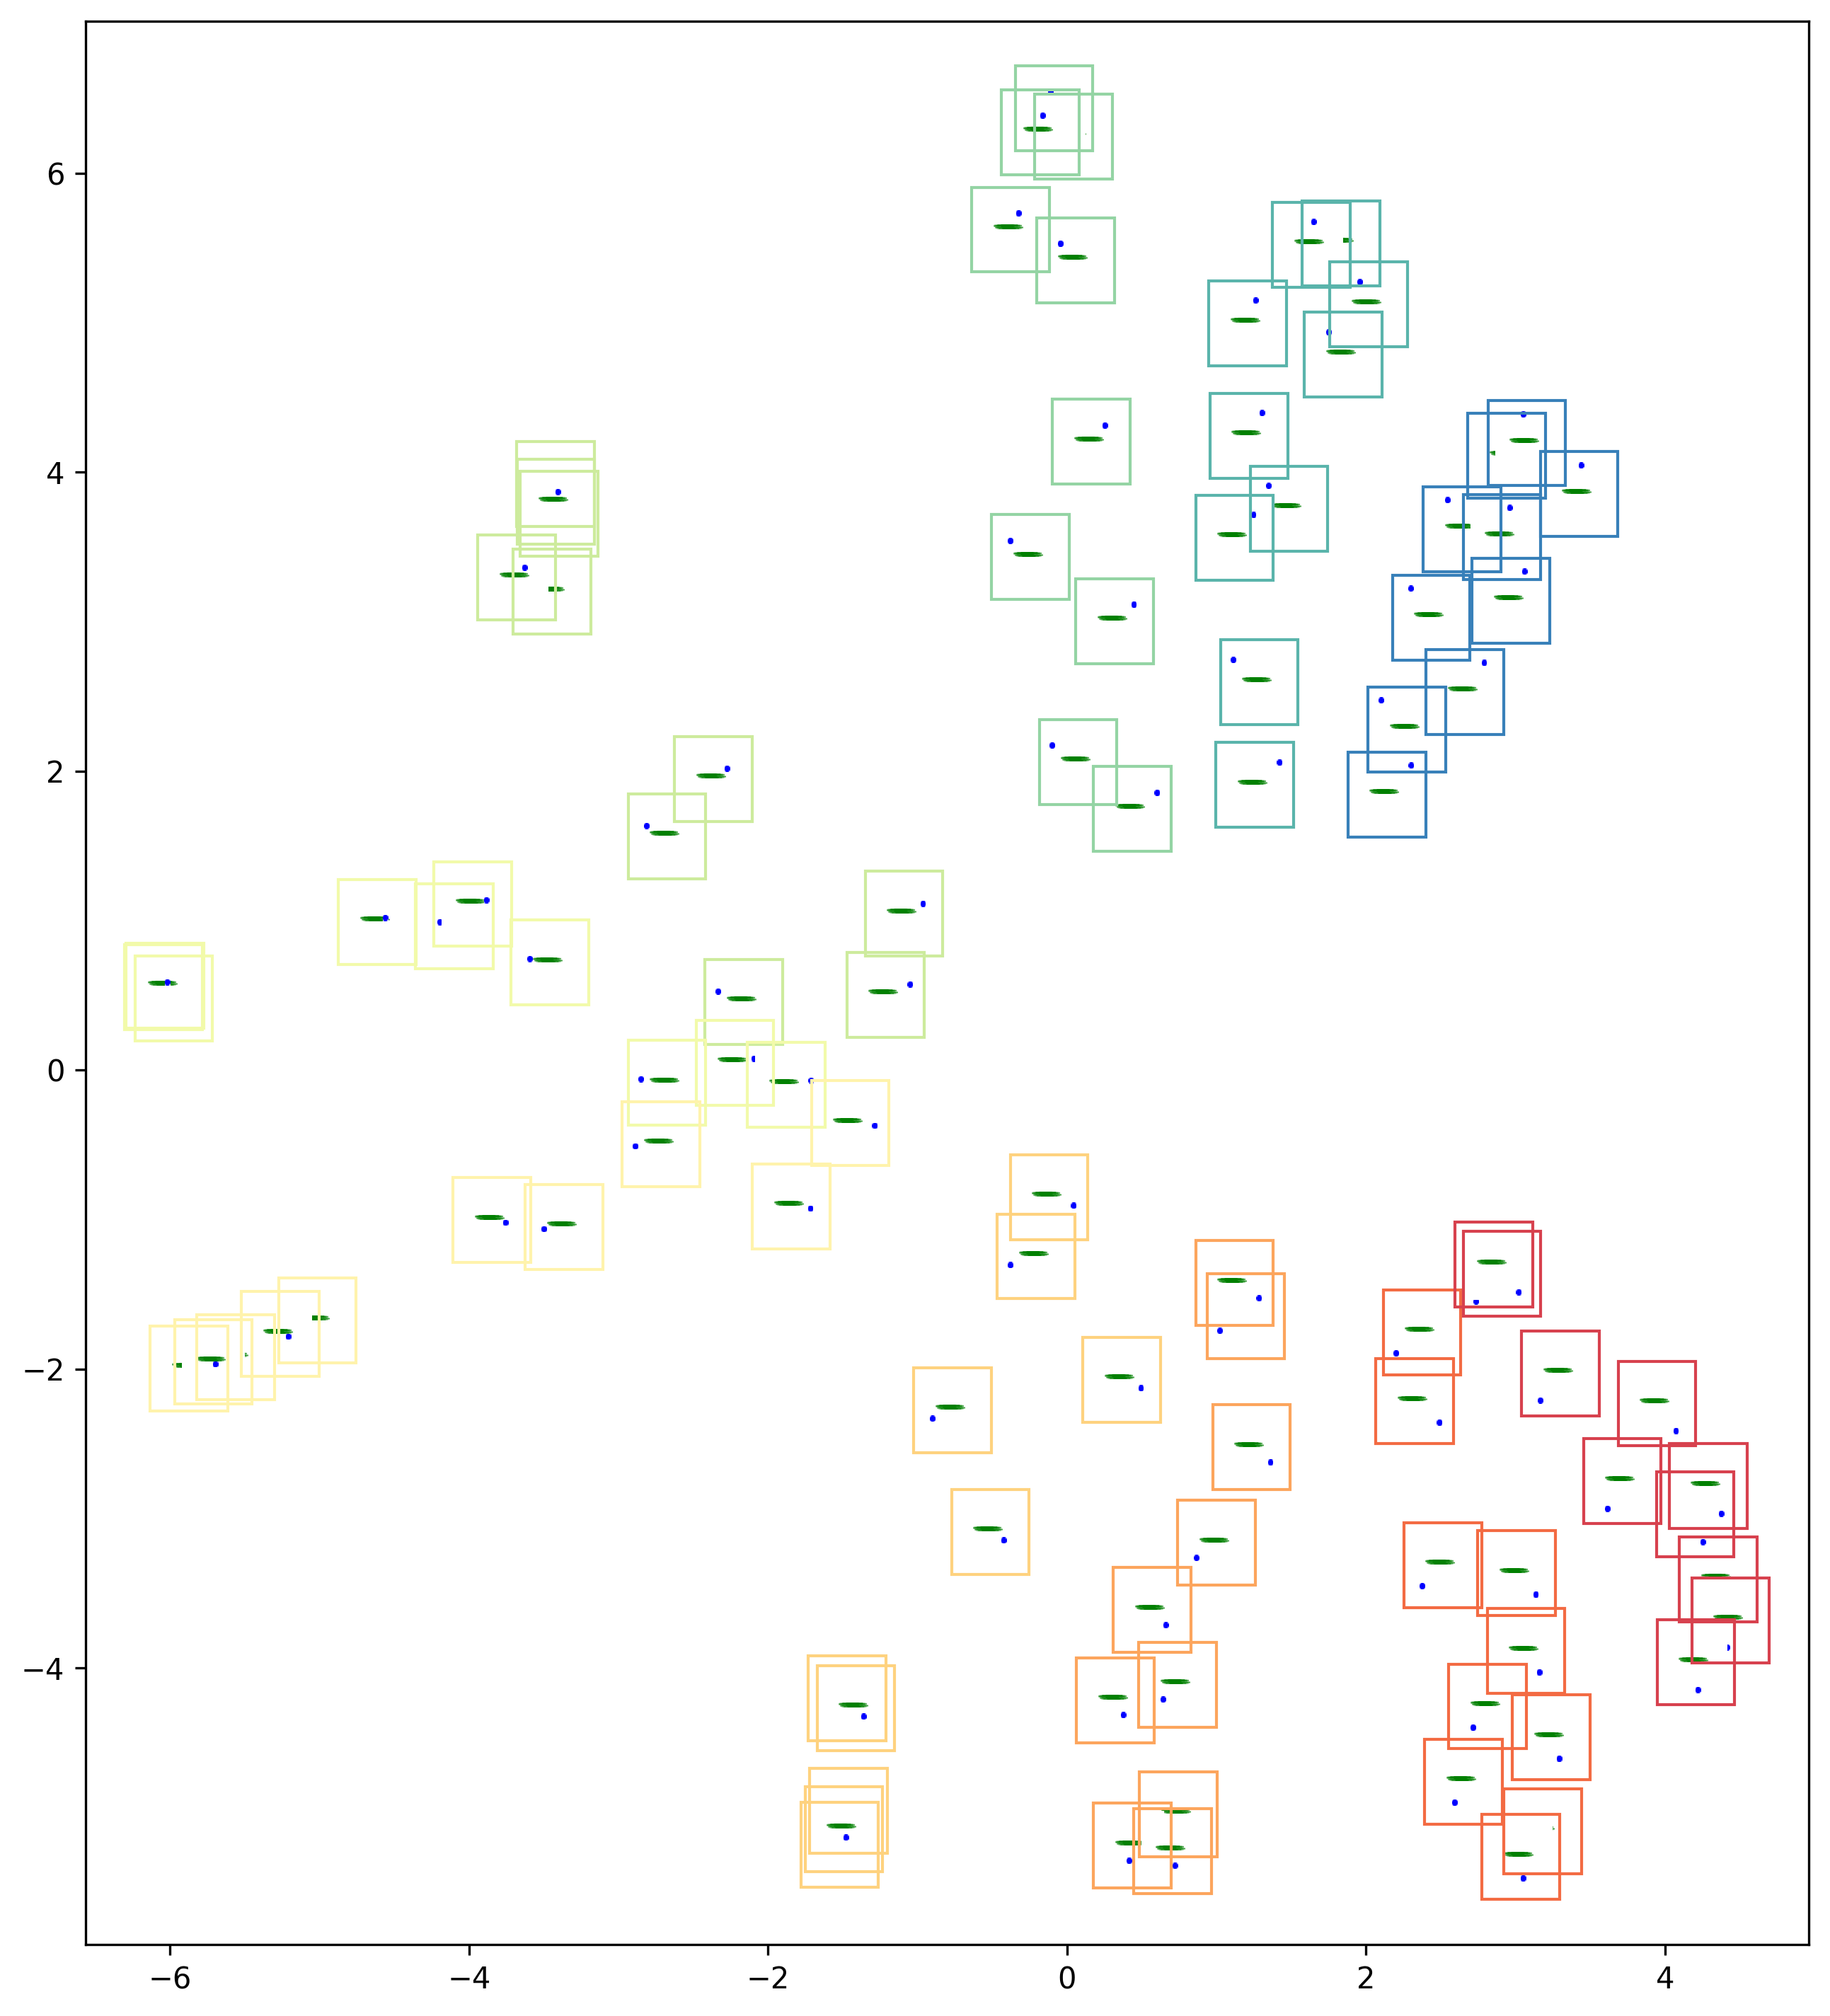

In [30]:
s_resnext50_32x4d = build_model(RESNEXT, device, pretrained=False, saycam='S')
analyze_single_model('TC-S-resnext', s_resnext50_32x4d, gen, target_positions, reference_positions)
analyze_single_model('TC-S-rexnext', s_resnext50_32x4d, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
del s_resnext50_32x4d

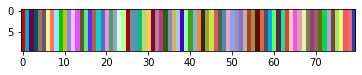

In [42]:
import numpy as np
import colorcet as cc
import matplotlib.pyplot as plt
import matplotlib

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
plt.imshow(xs, cmap=cc.cm.glasbey);  # use tab completion to choose

In [10]:
cc.cm.glasbey()

(0.050980000000000025, 0.913725, 0.635294, 1.0)

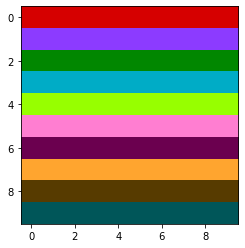

In [49]:
plt.imshow(np.expand_dims(np.arange(10), 1).repeat(10, axis=1), cmap=cc.cm.glasbey,
           norm=matplotlib.colors.Normalize(0, 255))

In [52]:
[int(x * 255) for x in cc.cm.glasbey(1)]

[140, 59, 255, 255]

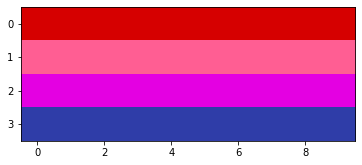

In [24]:
colors = np.array([0, 1, 2, 3])
plt.imshow(np.expand_dims(colors, 1).repeat(10, axis=1), cmap=cc.cm.glasbey)